C:\Users\Alpha\AppData\Local\Temp\ipykernel_23200\2314001497.py:80: UserWarning: Argument 'quality_lower' is not valid and will be ignored.
  A.GaussNoise(p=0.2), A.ImageCompression(quality_lower=85, p=0.2)


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\Alpha/.insightface\models\buffalo_l\1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\Alpha/.insightface\models\buffalo_l\2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\Alpha/.insightface\models\buffalo_l\det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\Alpha/.insightface\models\buffalo_l\genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\Alpha/.insightface\models\buffalo_l\w600k_r50.onnx recognition ['None', 3, 112, 112] 127.

Epoch 1: 100%|██████████| 15/15 [00:00<00:00, 16.90it/s, Loss=5.79, Acc=4.90%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.00      0.00      0.00         3
             Adrien_Brody       0.00      0.00      0.00         2
         Alejandro_Toledo       0.00      0.00      0.00         6
             Alvaro_Uribe       0.00      0.00      0.00         5
          Amelie_Mauresmo       0.00      0.00      0.00         3
             Andre_Agassi       0.00      0.00      0.00         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       0.00      0.00      0.00         3
              Ann_Veneman       0.00      0.00      0.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       0.00      0.00      0.00         2
             Ariel_Sharon       0.00      0.00      0.00        12
    Arnold_Schwarzenegger       0.00      0.00      0.00         6
     Atal_Bihari_Vajpay

Epoch 2: 100%|██████████| 15/15 [00:00<00:00, 15.61it/s, Loss=5.16, Acc=9.96%] 



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.00      0.00      0.00         3
             Adrien_Brody       0.00      0.00      0.00         2
         Alejandro_Toledo       0.00      0.00      0.00         6
             Alvaro_Uribe       0.00      0.00      0.00         5
          Amelie_Mauresmo       0.00      0.00      0.00         3
             Andre_Agassi       0.00      0.00      0.00         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       0.00      0.00      0.00         3
              Ann_Veneman       0.00      0.00      0.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       0.00      0.00      0.00         2
             Ariel_Sharon       0.00      0.00      0.00        12
    Arnold_Schwarzenegger       0.00      0.00      0.00         6
     Atal_Bihari_Vajpay

Epoch 3: 100%|██████████| 15/15 [00:00<00:00, 15.29it/s, Loss=5.09, Acc=11.10%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.00      0.00      0.00         3
             Adrien_Brody       0.00      0.00      0.00         2
         Alejandro_Toledo       0.00      0.00      0.00         6
             Alvaro_Uribe       0.00      0.00      0.00         5
          Amelie_Mauresmo       0.00      0.00      0.00         3
             Andre_Agassi       0.00      0.00      0.00         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       0.00      0.00      0.00         3
              Ann_Veneman       0.00      0.00      0.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       0.00      0.00      0.00         2
             Ariel_Sharon       0.00      0.00      0.00        12
    Arnold_Schwarzenegger       0.00      0.00      0.00         6
     Atal_Bihari_Vajpay

Epoch 4: 100%|██████████| 15/15 [00:00<00:00, 16.04it/s, Loss=5.12, Acc=14.34%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.00      0.00      0.00         3
             Adrien_Brody       0.00      0.00      0.00         2
         Alejandro_Toledo       0.00      0.00      0.00         6
             Alvaro_Uribe       0.00      0.00      0.00         5
          Amelie_Mauresmo       0.00      0.00      0.00         3
             Andre_Agassi       0.00      0.00      0.00         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       0.00      0.00      0.00         3
              Ann_Veneman       0.00      0.00      0.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       0.00      0.00      0.00         2
             Ariel_Sharon       1.00      0.08      0.15        12
    Arnold_Schwarzenegger       0.00      0.00      0.00         6
     Atal_Bihari_Vajpay

Epoch 5: 100%|██████████| 15/15 [00:00<00:00, 15.71it/s, Loss=4.35, Acc=16.11%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.00      0.00      0.00         3
             Adrien_Brody       0.00      0.00      0.00         2
         Alejandro_Toledo       0.00      0.00      0.00         6
             Alvaro_Uribe       0.00      0.00      0.00         5
          Amelie_Mauresmo       0.00      0.00      0.00         3
             Andre_Agassi       0.00      0.00      0.00         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       0.00      0.00      0.00         3
              Ann_Veneman       0.00      0.00      0.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       0.00      0.00      0.00         2
             Ariel_Sharon       0.86      0.50      0.63        12
    Arnold_Schwarzenegger       0.00      0.00      0.00         6
     Atal_Bihari_Vajpay

Epoch 6: 100%|██████████| 15/15 [00:00<00:00, 17.04it/s, Loss=4.48, Acc=20.38%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.00      0.00      0.00         3
             Adrien_Brody       0.00      0.00      0.00         2
         Alejandro_Toledo       0.00      0.00      0.00         6
             Alvaro_Uribe       0.00      0.00      0.00         5
          Amelie_Mauresmo       0.00      0.00      0.00         3
             Andre_Agassi       0.00      0.00      0.00         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       0.00      0.00      0.00         3
              Ann_Veneman       0.00      0.00      0.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       0.00      0.00      0.00         2
             Ariel_Sharon       0.67      0.67      0.67        12
    Arnold_Schwarzenegger       0.00      0.00      0.00         6
     Atal_Bihari_Vajpay

Epoch 7: 100%|██████████| 15/15 [00:00<00:00, 15.35it/s, Loss=4.29, Acc=21.90%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.00      0.00      0.00         3
             Adrien_Brody       0.00      0.00      0.00         2
         Alejandro_Toledo       0.00      0.00      0.00         6
             Alvaro_Uribe       0.50      0.20      0.29         5
          Amelie_Mauresmo       0.00      0.00      0.00         3
             Andre_Agassi       0.00      0.00      0.00         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       0.00      0.00      0.00         3
              Ann_Veneman       0.00      0.00      0.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       0.00      0.00      0.00         2
             Ariel_Sharon       0.56      0.75      0.64        12
    Arnold_Schwarzenegger       0.00      0.00      0.00         6
     Atal_Bihari_Vajpay

Epoch 8: 100%|██████████| 15/15 [00:00<00:00, 16.50it/s, Loss=4.72, Acc=25.09%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.00      0.00      0.00         3
             Adrien_Brody       0.00      0.00      0.00         2
         Alejandro_Toledo       0.00      0.00      0.00         6
             Alvaro_Uribe       0.00      0.00      0.00         5
          Amelie_Mauresmo       0.00      0.00      0.00         3
             Andre_Agassi       0.50      0.20      0.29         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       0.00      0.00      0.00         3
              Ann_Veneman       0.00      0.00      0.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       0.00      0.00      0.00         2
             Ariel_Sharon       0.38      0.92      0.54        12
    Arnold_Schwarzenegger       0.00      0.00      0.00         6
     Atal_Bihari_Vajpay

Epoch 9: 100%|██████████| 15/15 [00:00<00:00, 15.36it/s, Loss=3.8, Acc=28.90%] 



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.00      0.00      0.00         3
             Adrien_Brody       0.00      0.00      0.00         2
         Alejandro_Toledo       0.75      0.50      0.60         6
             Alvaro_Uribe       0.50      0.40      0.44         5
          Amelie_Mauresmo       0.00      0.00      0.00         3
             Andre_Agassi       0.33      0.20      0.25         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       0.00      0.00      0.00         3
              Ann_Veneman       0.00      0.00      0.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       0.00      0.00      0.00         2
             Ariel_Sharon       0.44      0.92      0.59        12
    Arnold_Schwarzenegger       0.50      0.17      0.25         6
     Atal_Bihari_Vajpay

Epoch 10: 100%|██████████| 15/15 [00:01<00:00, 14.29it/s, Loss=3.52, Acc=31.10%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.50      0.33      0.40         3
             Adrien_Brody       0.00      0.00      0.00         2
         Alejandro_Toledo       1.00      0.33      0.50         6
             Alvaro_Uribe       0.50      0.40      0.44         5
          Amelie_Mauresmo       0.00      0.00      0.00         3
             Andre_Agassi       0.75      0.60      0.67         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       0.00      0.00      0.00         3
              Ann_Veneman       0.00      0.00      0.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       0.00      0.00      0.00         2
             Ariel_Sharon       0.50      0.92      0.65        12
    Arnold_Schwarzenegger       0.40      0.33      0.36         6
     Atal_Bihari_Vajpay

Epoch 11: 100%|██████████| 15/15 [00:00<00:00, 15.32it/s, Loss=3.33, Acc=31.48%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      0.33      0.50         3
             Adrien_Brody       0.00      0.00      0.00         2
         Alejandro_Toledo       0.75      0.50      0.60         6
             Alvaro_Uribe       0.43      0.60      0.50         5
          Amelie_Mauresmo       1.00      0.33      0.50         3
             Andre_Agassi       0.67      0.80      0.73         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       0.00      0.00      0.00         3
              Ann_Veneman       0.00      0.00      0.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       0.00      0.00      0.00         2
             Ariel_Sharon       0.42      0.92      0.58        12
    Arnold_Schwarzenegger       1.00      0.17      0.29         6
     Atal_Bihari_Vajpay

Epoch 12: 100%|██████████| 15/15 [00:00<00:00, 16.12it/s, Loss=3.24, Acc=36.90%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.50      0.33      0.40         3
             Adrien_Brody       0.00      0.00      0.00         2
         Alejandro_Toledo       0.50      0.67      0.57         6
             Alvaro_Uribe       0.50      0.60      0.55         5
          Amelie_Mauresmo       1.00      0.67      0.80         3
             Andre_Agassi       0.67      0.80      0.73         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       0.00      0.00      0.00         3
              Ann_Veneman       0.00      0.00      0.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       0.00      0.00      0.00         2
             Ariel_Sharon       0.48      0.92      0.63        12
    Arnold_Schwarzenegger       0.50      0.83      0.62         6
     Atal_Bihari_Vajpay

Epoch 13: 100%|██████████| 15/15 [00:01<00:00, 13.67it/s, Loss=2.89, Acc=38.34%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.33      0.33      0.33         3
             Adrien_Brody       0.00      0.00      0.00         2
         Alejandro_Toledo       0.67      0.67      0.67         6
             Alvaro_Uribe       0.67      0.80      0.73         5
          Amelie_Mauresmo       1.00      0.33      0.50         3
             Andre_Agassi       0.80      0.80      0.80         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       0.00      0.00      0.00         3
              Ann_Veneman       0.00      0.00      0.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       0.00      0.00      0.00         2
             Ariel_Sharon       0.69      0.92      0.79        12
    Arnold_Schwarzenegger       0.55      1.00      0.71         6
     Atal_Bihari_Vajpay

Epoch 14: 100%|██████████| 15/15 [00:01<00:00, 14.49it/s, Loss=2.94, Acc=45.63%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.50      0.33      0.40         3
             Adrien_Brody       0.00      0.00      0.00         2
         Alejandro_Toledo       0.80      0.67      0.73         6
             Alvaro_Uribe       0.57      0.80      0.67         5
          Amelie_Mauresmo       1.00      0.67      0.80         3
             Andre_Agassi       0.50      0.80      0.62         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       0.00      0.00      0.00         3
              Ann_Veneman       0.00      0.00      0.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       0.00      0.00      0.00         2
             Ariel_Sharon       0.69      0.92      0.79        12
    Arnold_Schwarzenegger       0.50      1.00      0.67         6
     Atal_Bihari_Vajpay

Epoch 15: 100%|██████████| 15/15 [00:01<00:00, 14.87it/s, Loss=2.57, Acc=48.76%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.50      0.67      0.57         3
             Adrien_Brody       0.00      0.00      0.00         2
         Alejandro_Toledo       0.67      0.67      0.67         6
             Alvaro_Uribe       0.36      0.80      0.50         5
          Amelie_Mauresmo       1.00      0.67      0.80         3
             Andre_Agassi       0.50      1.00      0.67         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       0.00      0.00      0.00         3
              Ann_Veneman       0.00      0.00      0.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       0.00      0.00      0.00         2
             Ariel_Sharon       0.69      0.92      0.79        12
    Arnold_Schwarzenegger       0.67      1.00      0.80         6
     Atal_Bihari_Vajpay

Epoch 16: 100%|██████████| 15/15 [00:00<00:00, 15.23it/s, Loss=2.57, Acc=56.87%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      0.67      0.80         3
             Adrien_Brody       0.00      0.00      0.00         2
         Alejandro_Toledo       0.62      0.83      0.71         6
             Alvaro_Uribe       0.40      0.80      0.53         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.57      0.80      0.67         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       0.00      0.00      0.00         3
              Ann_Veneman       0.67      1.00      0.80         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       0.00      0.00      0.00         2
             Ariel_Sharon       0.73      0.92      0.81        12
    Arnold_Schwarzenegger       0.86      1.00      0.92         6
     Atal_Bihari_Vajpay

Epoch 17: 100%|██████████| 15/15 [00:01<00:00, 13.53it/s, Loss=3.78, Acc=57.25%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       0.00      0.00      0.00         2
         Alejandro_Toledo       0.57      0.67      0.62         6
             Alvaro_Uribe       0.57      0.80      0.67         5
          Amelie_Mauresmo       1.00      0.67      0.80         3
             Andre_Agassi       0.50      0.80      0.62         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       0.00      0.00      0.00         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       0.00      0.00      0.00         2
             Ariel_Sharon       0.69      0.92      0.79        12
    Arnold_Schwarzenegger       0.86      1.00      0.92         6
     Atal_Bihari_Vajpay

Epoch 18: 100%|██████████| 15/15 [00:01<00:00, 13.76it/s, Loss=2.45, Acc=60.14%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.75      1.00      0.86         3
             Adrien_Brody       0.00      0.00      0.00         2
         Alejandro_Toledo       0.80      0.67      0.73         6
             Alvaro_Uribe       0.67      0.80      0.73         5
          Amelie_Mauresmo       1.00      0.67      0.80         3
             Andre_Agassi       0.44      0.80      0.57         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       0.00      0.00      0.00         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       0.00      0.00      0.00         2
             Ariel_Sharon       0.73      0.92      0.81        12
    Arnold_Schwarzenegger       0.86      1.00      0.92         6
     Atal_Bihari_Vajpay

Epoch 19: 100%|██████████| 15/15 [00:01<00:00, 14.21it/s, Loss=1.99, Acc=66.10%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.75      1.00      0.86         3
             Adrien_Brody       1.00      0.50      0.67         2
         Alejandro_Toledo       0.57      0.67      0.62         6
             Alvaro_Uribe       0.67      0.80      0.73         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.67      0.80      0.73         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       0.00      0.00      0.00         3
              Ann_Veneman       0.67      1.00      0.80         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       0.00      0.00      0.00         2
             Ariel_Sharon       0.73      0.92      0.81        12
    Arnold_Schwarzenegger       0.67      1.00      0.80         6
     Atal_Bihari_Vajpay

Epoch 20: 100%|██████████| 15/15 [00:01<00:00, 14.73it/s, Loss=2.95, Acc=69.01%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       0.50      0.50      0.50         2
         Alejandro_Toledo       0.57      0.67      0.62         6
             Alvaro_Uribe       0.80      0.80      0.80         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.57      0.80      0.67         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       0.00      0.00      0.00         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       0.00      0.00      0.00         2
             Ariel_Sharon       0.85      0.92      0.88        12
    Arnold_Schwarzenegger       0.86      1.00      0.92         6
     Atal_Bihari_Vajpay

Epoch 21: 100%|██████████| 15/15 [00:00<00:00, 16.00it/s, Loss=1.68, Acc=70.31%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       0.50      0.50      0.50         2
         Alejandro_Toledo       1.00      0.67      0.80         6
             Alvaro_Uribe       0.80      0.80      0.80         5
          Amelie_Mauresmo       1.00      0.67      0.80         3
             Andre_Agassi       0.50      0.80      0.62         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       0.00      0.00      0.00         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       0.00      0.00      0.00         2
             Ariel_Sharon       0.92      0.92      0.92        12
    Arnold_Schwarzenegger       0.86      1.00      0.92         6
     Atal_Bihari_Vajpay

Epoch 22: 100%|██████████| 15/15 [00:01<00:00, 13.97it/s, Loss=1.61, Acc=76.19%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.75      1.00      0.86         3
             Adrien_Brody       0.67      1.00      0.80         2
         Alejandro_Toledo       1.00      0.67      0.80         6
             Alvaro_Uribe       0.80      0.80      0.80         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.67      0.80      0.73         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       0.00      0.00      0.00         3
              Ann_Veneman       0.67      1.00      0.80         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       0.00      0.00      0.00         2
             Ariel_Sharon       0.92      0.92      0.92        12
    Arnold_Schwarzenegger       0.86      1.00      0.92         6
     Atal_Bihari_Vajpay

Epoch 23: 100%|██████████| 15/15 [00:01<00:00, 13.88it/s, Loss=1.8, Acc=75.81%] 



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.75      1.00      0.86         3
             Adrien_Brody       0.67      1.00      0.80         2
         Alejandro_Toledo       0.80      0.67      0.73         6
             Alvaro_Uribe       0.80      0.80      0.80         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.57      0.80      0.67         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       0.00      0.00      0.00         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       0.00      0.00      0.00         2
             Ariel_Sharon       0.92      0.92      0.92        12
    Arnold_Schwarzenegger       0.86      1.00      0.92         6
     Atal_Bihari_Vajpay

Epoch 24: 100%|██████████| 15/15 [00:01<00:00, 13.64it/s, Loss=1.44, Acc=81.12%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       0.50      0.50      0.50         2
         Alejandro_Toledo       1.00      0.67      0.80         6
             Alvaro_Uribe       0.67      0.80      0.73         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.57      0.80      0.67         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       0.33      0.33      0.33         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.33      0.50      0.40         2
            Ari_Fleischer       0.00      0.00      0.00         2
             Ariel_Sharon       0.92      0.92      0.92        12
    Arnold_Schwarzenegger       1.00      1.00      1.00         6
     Atal_Bihari_Vajpay

Epoch 25: 100%|██████████| 15/15 [00:01<00:00, 13.69it/s, Loss=1.57, Acc=78.53%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       0.50      0.50      0.50         2
         Alejandro_Toledo       1.00      0.83      0.91         6
             Alvaro_Uribe       0.80      0.80      0.80         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.67      0.80      0.73         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       0.00      0.00      0.00         3
              Ann_Veneman       0.50      1.00      0.67         2
          Anna_Kournikova       0.33      0.50      0.40         2
            Ari_Fleischer       0.00      0.00      0.00         2
             Ariel_Sharon       0.92      0.92      0.92        12
    Arnold_Schwarzenegger       0.86      1.00      0.92         6
     Atal_Bihari_Vajpay

Epoch 26: 100%|██████████| 15/15 [00:01<00:00, 14.62it/s, Loss=1.43, Acc=81.17%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       0.67      1.00      0.80         2
         Alejandro_Toledo       1.00      0.67      0.80         6
             Alvaro_Uribe       0.80      0.80      0.80         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.67      0.80      0.73         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       0.00      0.00      0.00         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.33      0.50      0.40         2
            Ari_Fleischer       0.00      0.00      0.00         2
             Ariel_Sharon       1.00      0.92      0.96        12
    Arnold_Schwarzenegger       0.86      1.00      0.92         6
     Atal_Bihari_Vajpay

Epoch 27: 100%|██████████| 15/15 [00:01<00:00, 14.20it/s, Loss=1.35, Acc=76.24%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       0.67      1.00      0.80         2
         Alejandro_Toledo       1.00      0.67      0.80         6
             Alvaro_Uribe       0.80      0.80      0.80         5
          Amelie_Mauresmo       0.75      1.00      0.86         3
             Andre_Agassi       0.67      0.80      0.73         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       0.50      0.67      0.57         3
              Ann_Veneman       0.67      1.00      0.80         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       0.00      0.00      0.00         2
             Ariel_Sharon       0.85      0.92      0.88        12
    Arnold_Schwarzenegger       0.86      1.00      0.92         6
     Atal_Bihari_Vajpay

Epoch 28: 100%|██████████| 15/15 [00:01<00:00, 13.60it/s, Loss=1.28, Acc=85.39%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       0.67      1.00      0.80         2
         Alejandro_Toledo       1.00      0.67      0.80         6
             Alvaro_Uribe       1.00      0.80      0.89         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.67      0.80      0.73         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       0.00      0.00      0.00         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.50      0.50      0.50         2
            Ari_Fleischer       0.00      0.00      0.00         2
             Ariel_Sharon       0.79      0.92      0.85        12
    Arnold_Schwarzenegger       0.67      1.00      0.80         6
     Atal_Bihari_Vajpay

Epoch 29: 100%|██████████| 15/15 [00:00<00:00, 15.39it/s, Loss=1.37, Acc=93.55%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       0.50      0.50      0.50         2
         Alejandro_Toledo       1.00      0.67      0.80         6
             Alvaro_Uribe       0.67      0.80      0.73         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.80      0.80      0.80         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.33      0.50         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.50      0.50      0.50         2
            Ari_Fleischer       0.00      0.00      0.00         2
             Ariel_Sharon       0.92      0.92      0.92        12
    Arnold_Schwarzenegger       0.75      1.00      0.86         6
     Atal_Bihari_Vajpay

Epoch 30: 100%|██████████| 15/15 [00:01<00:00, 12.97it/s, Loss=1.21, Acc=85.74%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       0.67      1.00      0.80         2
         Alejandro_Toledo       1.00      0.83      0.91         6
             Alvaro_Uribe       0.80      0.80      0.80         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.80      0.80      0.80         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       0.00      0.00      0.00         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.33      0.50      0.40         2
            Ari_Fleischer       0.00      0.00      0.00         2
             Ariel_Sharon       0.73      0.92      0.81        12
    Arnold_Schwarzenegger       0.67      1.00      0.80         6
     Atal_Bihari_Vajpay

Epoch 31: 100%|██████████| 15/15 [00:01<00:00, 14.50it/s, Loss=1.18, Acc=95.27%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       0.67      1.00      0.80         2
         Alejandro_Toledo       1.00      0.67      0.80         6
             Alvaro_Uribe       1.00      0.80      0.89         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.80      0.80      0.80         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       0.00      0.00      0.00         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.33      0.50      0.40         2
            Ari_Fleischer       0.00      0.00      0.00         2
             Ariel_Sharon       0.85      0.92      0.88        12
    Arnold_Schwarzenegger       0.60      1.00      0.75         6
     Atal_Bihari_Vajpay

Epoch 32: 100%|██████████| 15/15 [00:01<00:00, 12.87it/s, Loss=1.16, Acc=87.24%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       0.50      0.50      0.50         2
         Alejandro_Toledo       1.00      0.67      0.80         6
             Alvaro_Uribe       0.67      0.80      0.73         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.80      0.80      0.80         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.33      0.50         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       0.00      0.00      0.00         2
             Ariel_Sharon       0.79      0.92      0.85        12
    Arnold_Schwarzenegger       0.55      1.00      0.71         6
     Atal_Bihari_Vajpay

Epoch 33: 100%|██████████| 15/15 [00:01<00:00, 14.22it/s, Loss=1.15, Acc=89.80%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       0.67      1.00      0.80         2
         Alejandro_Toledo       1.00      0.67      0.80         6
             Alvaro_Uribe       0.50      0.80      0.62         5
          Amelie_Mauresmo       0.50      1.00      0.67         3
             Andre_Agassi       0.80      0.80      0.80         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.33      0.50         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       0.00      0.00      0.00         2
             Ariel_Sharon       0.92      0.92      0.92        12
    Arnold_Schwarzenegger       0.67      1.00      0.80         6
     Atal_Bihari_Vajpay

Epoch 34: 100%|██████████| 15/15 [00:01<00:00, 13.83it/s, Loss=1.15, Acc=91.56%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       0.67      1.00      0.80         2
         Alejandro_Toledo       1.00      0.67      0.80         6
             Alvaro_Uribe       0.57      0.80      0.67         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.80      0.80      0.80         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       0.50      0.67      0.57         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       0.00      0.00      0.00         2
             Ariel_Sharon       0.85      0.92      0.88        12
    Arnold_Schwarzenegger       0.86      1.00      0.92         6
     Atal_Bihari_Vajpay

Epoch 35: 100%|██████████| 15/15 [00:01<00:00, 13.43it/s, Loss=2.33, Acc=92.76%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       0.67      1.00      0.80         2
         Alejandro_Toledo       1.00      0.67      0.80         6
             Alvaro_Uribe       1.00      0.80      0.89         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.75      0.60      0.67         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.33      0.50         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       0.00      0.00      0.00         2
             Ariel_Sharon       0.73      0.92      0.81        12
    Arnold_Schwarzenegger       0.75      1.00      0.86         6
     Atal_Bihari_Vajpay

Epoch 36: 100%|██████████| 15/15 [00:01<00:00, 12.87it/s, Loss=1.07, Acc=94.48%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.75      1.00      0.86         3
             Adrien_Brody       0.50      0.50      0.50         2
         Alejandro_Toledo       1.00      0.67      0.80         6
             Alvaro_Uribe       1.00      0.80      0.89         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.67      0.80      0.73         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       0.00      0.00      0.00         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.50      0.50      0.50         2
            Ari_Fleischer       0.00      0.00      0.00         2
             Ariel_Sharon       0.65      0.92      0.76        12
    Arnold_Schwarzenegger       0.86      1.00      0.92         6
     Atal_Bihari_Vajpay

Epoch 37: 100%|██████████| 15/15 [00:01<00:00, 12.52it/s, Loss=1.16, Acc=94.64%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       0.67      1.00      0.80         2
         Alejandro_Toledo       1.00      0.67      0.80         6
             Alvaro_Uribe       0.80      0.80      0.80         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.80      0.80      0.80         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       0.00      0.00      0.00         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       1.00      0.50      0.67         2
            Ari_Fleischer       0.00      0.00      0.00         2
             Ariel_Sharon       1.00      0.92      0.96        12
    Arnold_Schwarzenegger       0.75      1.00      0.86         6
     Atal_Bihari_Vajpay

Epoch 38: 100%|██████████| 15/15 [00:01<00:00, 13.03it/s, Loss=1.07, Acc=97.63%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.75      1.00      0.86         3
             Adrien_Brody       0.67      1.00      0.80         2
         Alejandro_Toledo       1.00      0.67      0.80         6
             Alvaro_Uribe       0.80      0.80      0.80         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.67      0.80      0.73         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       0.00      0.00      0.00         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       0.00      0.00      0.00         2
             Ariel_Sharon       0.85      0.92      0.88        12
    Arnold_Schwarzenegger       0.75      1.00      0.86         6
     Atal_Bihari_Vajpay

Epoch 39: 100%|██████████| 15/15 [00:01<00:00, 14.53it/s, Loss=1.09, Acc=95.21%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.75      1.00      0.86         3
             Adrien_Brody       0.67      1.00      0.80         2
         Alejandro_Toledo       1.00      0.67      0.80         6
             Alvaro_Uribe       1.00      0.80      0.89         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.67      0.80      0.73         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       0.00      0.00      0.00         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       0.00      0.00      0.00         2
             Ariel_Sharon       0.79      0.92      0.85        12
    Arnold_Schwarzenegger       0.86      1.00      0.92         6
     Atal_Bihari_Vajpay

Epoch 40: 100%|██████████| 15/15 [00:01<00:00, 14.02it/s, Loss=1.06, Acc=90.61%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       0.67      1.00      0.80         2
         Alejandro_Toledo       1.00      0.67      0.80         6
             Alvaro_Uribe       0.80      0.80      0.80         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.67      0.80      0.73         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.33      0.50         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       0.00      0.00      0.00         2
             Ariel_Sharon       0.85      0.92      0.88        12
    Arnold_Schwarzenegger       0.86      1.00      0.92         6
     Atal_Bihari_Vajpay

Epoch 41: 100%|██████████| 15/15 [00:01<00:00, 13.08it/s, Loss=1.04, Acc=98.42%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.75      1.00      0.86         3
             Adrien_Brody       0.67      1.00      0.80         2
         Alejandro_Toledo       1.00      0.67      0.80         6
             Alvaro_Uribe       1.00      0.80      0.89         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.67      0.80      0.73         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.33      0.50         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       0.00      0.00      0.00         2
             Ariel_Sharon       0.79      0.92      0.85        12
    Arnold_Schwarzenegger       0.86      1.00      0.92         6
     Atal_Bihari_Vajpay

Epoch 42: 100%|██████████| 15/15 [00:01<00:00, 14.55it/s, Loss=2.26, Acc=90.15%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.60      1.00      0.75         3
             Adrien_Brody       0.67      1.00      0.80         2
         Alejandro_Toledo       1.00      0.67      0.80         6
             Alvaro_Uribe       1.00      0.80      0.89         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.57      0.80      0.67         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.33      0.50         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       0.00      0.00      0.00         2
             Ariel_Sharon       0.79      0.92      0.85        12
    Arnold_Schwarzenegger       1.00      1.00      1.00         6
     Atal_Bihari_Vajpay

Epoch 43: 100%|██████████| 15/15 [00:01<00:00, 13.56it/s, Loss=1.04, Acc=87.97%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       0.67      1.00      0.80         2
         Alejandro_Toledo       0.67      0.67      0.67         6
             Alvaro_Uribe       0.80      0.80      0.80         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.67      0.80      0.73         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.33      0.50         3
              Ann_Veneman       0.50      1.00      0.67         2
          Anna_Kournikova       0.33      0.50      0.40         2
            Ari_Fleischer       0.00      0.00      0.00         2
             Ariel_Sharon       0.75      1.00      0.86        12
    Arnold_Schwarzenegger       0.83      0.83      0.83         6
     Atal_Bihari_Vajpay

Epoch 44: 100%|██████████| 15/15 [00:01<00:00, 12.72it/s, Loss=1.05, Acc=93.31%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       0.67      1.00      0.80         2
         Alejandro_Toledo       1.00      0.50      0.67         6
             Alvaro_Uribe       0.67      0.80      0.73         5
          Amelie_Mauresmo       0.75      1.00      0.86         3
             Andre_Agassi       1.00      0.80      0.89         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.33      0.50         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.50      0.50      0.50         2
            Ari_Fleischer       0.00      0.00      0.00         2
             Ariel_Sharon       0.73      0.92      0.81        12
    Arnold_Schwarzenegger       1.00      0.83      0.91         6
     Atal_Bihari_Vajpay

Epoch 45: 100%|██████████| 15/15 [00:01<00:00, 11.86it/s, Loss=1.03, Acc=99.24%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       0.67      1.00      0.80         2
         Alejandro_Toledo       1.00      0.67      0.80         6
             Alvaro_Uribe       0.50      0.80      0.62         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.80      0.80      0.80         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.33      0.50         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       0.00      0.00      0.00         2
             Ariel_Sharon       0.92      0.92      0.92        12
    Arnold_Schwarzenegger       0.83      0.83      0.83         6
     Atal_Bihari_Vajpay

Epoch 46: 100%|██████████| 15/15 [00:01<00:00, 12.47it/s, Loss=1.01, Acc=91.70%] 



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       0.50      0.50      0.50         2
         Alejandro_Toledo       1.00      0.67      0.80         6
             Alvaro_Uribe       0.80      0.80      0.80         5
          Amelie_Mauresmo       0.75      1.00      0.86         3
             Andre_Agassi       0.33      0.80      0.47         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.33      0.50         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       0.00      0.00      0.00         2
             Ariel_Sharon       0.85      0.92      0.88        12
    Arnold_Schwarzenegger       0.62      0.83      0.71         6
     Atal_Bihari_Vajpay

Epoch 47: 100%|██████████| 15/15 [00:01<00:00, 13.23it/s, Loss=1.03, Acc=94.34%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       0.67      1.00      0.80         2
         Alejandro_Toledo       1.00      0.67      0.80         6
             Alvaro_Uribe       0.80      0.80      0.80         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.50      0.80      0.62         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       0.50      0.33      0.40         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       0.00      0.00      0.00         2
             Ariel_Sharon       0.73      0.92      0.81        12
    Arnold_Schwarzenegger       1.00      1.00      1.00         6
     Atal_Bihari_Vajpay

Epoch 48: 100%|██████████| 15/15 [00:01<00:00, 12.24it/s, Loss=1, Acc=94.88%]    



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       0.50      1.00      0.67         2
         Alejandro_Toledo       1.00      0.67      0.80         6
             Alvaro_Uribe       0.67      0.80      0.73         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.57      0.80      0.67         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.33      0.50         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.50      0.50      0.50         2
            Ari_Fleischer       0.00      0.00      0.00         2
             Ariel_Sharon       0.92      0.92      0.92        12
    Arnold_Schwarzenegger       1.00      0.83      0.91         6
     Atal_Bihari_Vajpay

Epoch 49: 100%|██████████| 15/15 [00:01<00:00, 12.57it/s, Loss=1.06, Acc=92.52%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       0.67      1.00      0.80         2
         Alejandro_Toledo       0.67      0.67      0.67         6
             Alvaro_Uribe       1.00      0.80      0.89         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.50      1.00      0.67         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       0.33      0.33      0.33         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       1.00      0.50      0.67         2
            Ari_Fleischer       0.00      0.00      0.00         2
             Ariel_Sharon       0.73      0.92      0.81        12
    Arnold_Schwarzenegger       1.00      0.83      0.91         6
     Atal_Bihari_Vajpay

Epoch 50: 100%|██████████| 15/15 [00:01<00:00, 12.56it/s, Loss=1.15, Acc=97.03%] 



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       0.67      1.00      0.80         2
         Alejandro_Toledo       1.00      0.67      0.80         6
             Alvaro_Uribe       0.80      0.80      0.80         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.57      0.80      0.67         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.33      0.50         3
              Ann_Veneman       0.67      1.00      0.80         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       0.00      0.00      0.00         2
             Ariel_Sharon       0.85      0.92      0.88        12
    Arnold_Schwarzenegger       1.00      0.67      0.80         6
     Atal_Bihari_Vajpay

Epoch 51: 100%|██████████| 15/15 [00:01<00:00, 13.44it/s, Loss=0.967, Acc=95.70%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       0.67      1.00      0.80         2
         Alejandro_Toledo       0.80      0.67      0.73         6
             Alvaro_Uribe       0.80      0.80      0.80         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.50      0.80      0.62         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.33      0.50         3
              Ann_Veneman       0.50      1.00      0.67         2
          Anna_Kournikova       1.00      0.50      0.67         2
            Ari_Fleischer       0.00      0.00      0.00         2
             Ariel_Sharon       0.85      0.92      0.88        12
    Arnold_Schwarzenegger       1.00      0.83      0.91         6
     Atal_Bihari_Vajpay

Epoch 52: 100%|██████████| 15/15 [00:01<00:00, 13.11it/s, Loss=1, Acc=92.49%]    



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       0.50      1.00      0.67         2
         Alejandro_Toledo       0.83      0.83      0.83         6
             Alvaro_Uribe       0.80      0.80      0.80         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.80      0.80      0.80         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       0.00      0.00      0.00         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       1.00      0.50      0.67         2
            Ari_Fleischer       0.00      0.00      0.00         2
             Ariel_Sharon       0.92      0.92      0.92        12
    Arnold_Schwarzenegger       0.86      1.00      0.92         6
     Atal_Bihari_Vajpay

Epoch 53: 100%|██████████| 15/15 [00:01<00:00, 13.18it/s, Loss=0.977, Acc=95.56%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.75      1.00      0.86         3
             Adrien_Brody       0.67      1.00      0.80         2
         Alejandro_Toledo       1.00      0.67      0.80         6
             Alvaro_Uribe       0.57      0.80      0.67         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.44      0.80      0.57         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.33      0.50         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       1.00      0.50      0.67         2
            Ari_Fleischer       0.00      0.00      0.00         2
             Ariel_Sharon       0.85      0.92      0.88        12
    Arnold_Schwarzenegger       1.00      1.00      1.00         6
     Atal_Bihari_Vajpay

Epoch 54: 100%|██████████| 15/15 [00:01<00:00, 13.43it/s, Loss=1.01, Acc=89.25%] 



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      0.67      0.80         3
             Adrien_Brody       0.67      1.00      0.80         2
         Alejandro_Toledo       1.00      0.83      0.91         6
             Alvaro_Uribe       0.80      0.80      0.80         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.50      0.80      0.62         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       0.00      0.00      0.00         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.50      0.50      0.50         2
            Ari_Fleischer       0.00      0.00      0.00         2
             Ariel_Sharon       0.73      0.92      0.81        12
    Arnold_Schwarzenegger       0.75      1.00      0.86         6
     Atal_Bihari_Vajpay

Epoch 55: 100%|██████████| 15/15 [00:01<00:00, 12.51it/s, Loss=0.995, Acc=99.24%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      0.67      0.80         3
             Adrien_Brody       0.67      1.00      0.80         2
         Alejandro_Toledo       1.00      0.67      0.80         6
             Alvaro_Uribe       0.67      0.80      0.73         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.67      0.80      0.73         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       0.00      0.00      0.00         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       0.00      0.00      0.00         2
             Ariel_Sharon       0.69      0.92      0.79        12
    Arnold_Schwarzenegger       0.86      1.00      0.92         6
     Atal_Bihari_Vajpay

Epoch 56: 100%|██████████| 15/15 [00:01<00:00, 13.15it/s, Loss=2, Acc=93.12%]    



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       0.67      1.00      0.80         2
         Alejandro_Toledo       0.83      0.83      0.83         6
             Alvaro_Uribe       0.80      0.80      0.80         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       1.00      0.80      0.89         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.33      0.50         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       0.00      0.00      0.00         2
             Ariel_Sharon       0.85      0.92      0.88        12
    Arnold_Schwarzenegger       1.00      1.00      1.00         6
     Atal_Bihari_Vajpay

Epoch 57: 100%|██████████| 15/15 [00:01<00:00, 13.72it/s, Loss=0.988, Acc=95.27%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.60      1.00      0.75         3
             Adrien_Brody       0.67      1.00      0.80         2
         Alejandro_Toledo       1.00      0.67      0.80         6
             Alvaro_Uribe       0.80      0.80      0.80         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       1.00      0.80      0.89         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.33      0.50         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       0.00      0.00      0.00         2
             Ariel_Sharon       1.00      0.92      0.96        12
    Arnold_Schwarzenegger       1.00      1.00      1.00         6
     Atal_Bihari_Vajpay

Epoch 58: 100%|██████████| 15/15 [00:01<00:00, 13.32it/s, Loss=0.956, Acc=99.48%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.75      1.00      0.86         3
             Adrien_Brody       0.67      1.00      0.80         2
         Alejandro_Toledo       0.80      0.67      0.73         6
             Alvaro_Uribe       1.00      0.80      0.89         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.43      0.60      0.50         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       0.00      0.00      0.00         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       0.00      0.00      0.00         2
             Ariel_Sharon       1.00      0.92      0.96        12
    Arnold_Schwarzenegger       1.00      1.00      1.00         6
     Atal_Bihari_Vajpay

Epoch 59: 100%|██████████| 15/15 [00:01<00:00, 13.71it/s, Loss=0.946, Acc=91.92%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       0.71      0.83      0.77         6
             Alvaro_Uribe       0.80      0.80      0.80         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.67      0.80      0.73         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       0.00      0.00      0.00         3
              Ann_Veneman       0.67      1.00      0.80         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       0.00      0.00      0.00         2
             Ariel_Sharon       0.85      0.92      0.88        12
    Arnold_Schwarzenegger       1.00      1.00      1.00         6
     Atal_Bihari_Vajpay

Epoch 60: 100%|██████████| 15/15 [00:00<00:00, 15.23it/s, Loss=0.975, Acc=97.80%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.67      0.67      0.67         3
             Adrien_Brody       0.67      1.00      0.80         2
         Alejandro_Toledo       0.83      0.83      0.83         6
             Alvaro_Uribe       0.80      0.80      0.80         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.60      0.60      0.60         5
             Andy_Roddick       0.50      0.50      0.50         2
           Angelina_Jolie       1.00      0.33      0.50         3
              Ann_Veneman       0.67      1.00      0.80         2
          Anna_Kournikova       0.33      0.50      0.40         2
            Ari_Fleischer       0.00      0.00      0.00         2
             Ariel_Sharon       0.85      0.92      0.88        12
    Arnold_Schwarzenegger       0.86      1.00      0.92         6
     Atal_Bihari_Vajpay

Epoch 61: 100%|██████████| 15/15 [00:00<00:00, 15.24it/s, Loss=0.977, Acc=95.92%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      0.67      0.80         3
             Adrien_Brody       0.67      1.00      0.80         2
         Alejandro_Toledo       0.80      0.67      0.73         6
             Alvaro_Uribe       0.67      0.80      0.73         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       1.00      0.80      0.89         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.33      0.50         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       1.00      0.50      0.67         2
            Ari_Fleischer       0.00      0.00      0.00         2
             Ariel_Sharon       0.85      0.92      0.88        12
    Arnold_Schwarzenegger       1.00      1.00      1.00         6
     Atal_Bihari_Vajpay

Epoch 62: 100%|██████████| 15/15 [00:01<00:00, 14.78it/s, Loss=0.932, Acc=98.31%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       0.67      1.00      0.80         2
         Alejandro_Toledo       0.80      0.67      0.73         6
             Alvaro_Uribe       0.80      0.80      0.80         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.80      0.80      0.80         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.33      0.50         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.50      0.50      0.50         2
            Ari_Fleischer       0.00      0.00      0.00         2
             Ariel_Sharon       0.92      0.92      0.92        12
    Arnold_Schwarzenegger       1.00      1.00      1.00         6
     Atal_Bihari_Vajpay

Epoch 63: 100%|██████████| 15/15 [00:00<00:00, 15.21it/s, Loss=0.971, Acc=96.68%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       0.67      1.00      0.80         2
         Alejandro_Toledo       1.00      0.67      0.80         6
             Alvaro_Uribe       0.80      0.80      0.80         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.57      0.80      0.67         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.25      0.50      0.33         2
            Ari_Fleischer       0.00      0.00      0.00         2
             Ariel_Sharon       0.73      0.92      0.81        12
    Arnold_Schwarzenegger       0.86      1.00      0.92         6
     Atal_Bihari_Vajpay

Epoch 64: 100%|██████████| 15/15 [00:01<00:00, 12.41it/s, Loss=1.07, Acc=98.29%] 



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       0.67      1.00      0.80         2
         Alejandro_Toledo       1.00      0.67      0.80         6
             Alvaro_Uribe       0.80      0.80      0.80         5
          Amelie_Mauresmo       0.75      1.00      0.86         3
             Andre_Agassi       0.67      0.80      0.73         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.33      0.50         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.33      0.50      0.40         2
            Ari_Fleischer       0.00      0.00      0.00         2
             Ariel_Sharon       0.92      0.92      0.92        12
    Arnold_Schwarzenegger       0.83      0.83      0.83         6
     Atal_Bihari_Vajpay

Epoch 65: 100%|██████████| 15/15 [00:01<00:00, 14.09it/s, Loss=0.918, Acc=95.54%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       0.67      1.00      0.80         2
         Alejandro_Toledo       0.71      0.83      0.77         6
             Alvaro_Uribe       0.80      0.80      0.80         5
          Amelie_Mauresmo       0.75      1.00      0.86         3
             Andre_Agassi       0.80      0.80      0.80         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.33      0.50         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.33      0.50      0.40         2
            Ari_Fleischer       0.00      0.00      0.00         2
             Ariel_Sharon       0.85      0.92      0.88        12
    Arnold_Schwarzenegger       1.00      0.83      0.91         6
     Atal_Bihari_Vajpay

Epoch 66: 100%|██████████| 15/15 [00:01<00:00, 13.79it/s, Loss=0.916, Acc=98.45%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       0.67      1.00      0.80         2
         Alejandro_Toledo       1.00      0.67      0.80         6
             Alvaro_Uribe       0.67      0.80      0.73         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.42      1.00      0.59         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.33      0.50         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       0.00      0.00      0.00         2
             Ariel_Sharon       0.73      0.92      0.81        12
    Arnold_Schwarzenegger       0.86      1.00      0.92         6
     Atal_Bihari_Vajpay

Epoch 67: 100%|██████████| 15/15 [00:01<00:00, 13.55it/s, Loss=1.69, Acc=94.72%] 



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       0.67      1.00      0.80         2
         Alejandro_Toledo       1.00      0.83      0.91         6
             Alvaro_Uribe       0.80      0.80      0.80         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.83      1.00      0.91         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       0.00      0.00      0.00         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       0.00      0.00      0.00         2
             Ariel_Sharon       1.00      0.92      0.96        12
    Arnold_Schwarzenegger       0.75      1.00      0.86         6
     Atal_Bihari_Vajpay

Epoch 68: 100%|██████████| 15/15 [00:01<00:00, 12.36it/s, Loss=0.914, Acc=95.32%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       0.67      1.00      0.80         2
         Alejandro_Toledo       0.83      0.83      0.83         6
             Alvaro_Uribe       1.00      0.80      0.89         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.80      0.80      0.80         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       0.33      0.33      0.33         3
              Ann_Veneman       0.67      1.00      0.80         2
          Anna_Kournikova       0.50      0.50      0.50         2
            Ari_Fleischer       0.00      0.00      0.00         2
             Ariel_Sharon       0.92      0.92      0.92        12
    Arnold_Schwarzenegger       1.00      1.00      1.00         6
     Atal_Bihari_Vajpay

Epoch 69: 100%|██████████| 15/15 [00:01<00:00, 13.92it/s, Loss=0.921, Acc=99.78%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      0.67      0.80         3
             Adrien_Brody       0.67      1.00      0.80         2
         Alejandro_Toledo       0.83      0.83      0.83         6
             Alvaro_Uribe       0.80      0.80      0.80         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.80      0.80      0.80         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       0.50      0.33      0.40         3
              Ann_Veneman       0.67      1.00      0.80         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       0.00      0.00      0.00         2
             Ariel_Sharon       1.00      0.92      0.96        12
    Arnold_Schwarzenegger       1.00      1.00      1.00         6
     Atal_Bihari_Vajpay

Epoch 70: 100%|██████████| 15/15 [00:01<00:00, 13.71it/s, Loss=0.966, Acc=98.39%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.75      1.00      0.86         3
             Adrien_Brody       0.67      1.00      0.80         2
         Alejandro_Toledo       1.00      0.83      0.91         6
             Alvaro_Uribe       0.80      0.80      0.80         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.50      0.80      0.62         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.33      0.50         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.50      0.50      0.50         2
            Ari_Fleischer       0.00      0.00      0.00         2
             Ariel_Sharon       0.92      0.92      0.92        12
    Arnold_Schwarzenegger       1.00      1.00      1.00         6
     Atal_Bihari_Vajpay

Epoch 71: 100%|██████████| 15/15 [00:01<00:00, 10.94it/s, Loss=0.921, Acc=98.69%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       0.67      1.00      0.80         2
         Alejandro_Toledo       1.00      0.67      0.80         6
             Alvaro_Uribe       0.67      0.80      0.73         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.57      0.80      0.67         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.33      0.50         3
              Ann_Veneman       0.67      1.00      0.80         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       0.00      0.00      0.00         2
             Ariel_Sharon       0.92      0.92      0.92        12
    Arnold_Schwarzenegger       0.75      1.00      0.86         6
     Atal_Bihari_Vajpay

Epoch 72: 100%|██████████| 15/15 [00:01<00:00, 13.18it/s, Loss=0.957, Acc=98.29%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       0.67      1.00      0.80         2
         Alejandro_Toledo       1.00      0.67      0.80         6
             Alvaro_Uribe       1.00      0.80      0.89         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       1.00      0.80      0.89         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.33      0.50         3
              Ann_Veneman       0.67      1.00      0.80         2
          Anna_Kournikova       0.50      0.50      0.50         2
            Ari_Fleischer       0.00      0.00      0.00         2
             Ariel_Sharon       0.92      0.92      0.92        12
    Arnold_Schwarzenegger       0.86      1.00      0.92         6
     Atal_Bihari_Vajpay

Epoch 73: 100%|██████████| 15/15 [00:01<00:00, 14.44it/s, Loss=0.897, Acc=98.61%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       0.67      1.00      0.80         2
         Alejandro_Toledo       1.00      0.83      0.91         6
             Alvaro_Uribe       0.80      0.80      0.80         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.50      0.80      0.62         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.33      0.50         3
              Ann_Veneman       0.67      1.00      0.80         2
          Anna_Kournikova       0.50      0.50      0.50         2
            Ari_Fleischer       0.00      0.00      0.00         2
             Ariel_Sharon       0.85      0.92      0.88        12
    Arnold_Schwarzenegger       0.86      1.00      0.92         6
     Atal_Bihari_Vajpay

Epoch 74: 100%|██████████| 15/15 [00:01<00:00, 14.54it/s, Loss=0.916, Acc=96.33%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.75      1.00      0.86         3
             Adrien_Brody       0.67      1.00      0.80         2
         Alejandro_Toledo       1.00      0.83      0.91         6
             Alvaro_Uribe       0.80      0.80      0.80         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.80      0.80      0.80         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.33      0.50         3
              Ann_Veneman       0.67      1.00      0.80         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       0.00      0.00      0.00         2
             Ariel_Sharon       0.92      0.92      0.92        12
    Arnold_Schwarzenegger       1.00      1.00      1.00         6
     Atal_Bihari_Vajpay

Epoch 75: 100%|██████████| 15/15 [00:01<00:00, 14.82it/s, Loss=0.897, Acc=98.97%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.75      1.00      0.86         3
             Adrien_Brody       0.67      1.00      0.80         2
         Alejandro_Toledo       1.00      0.83      0.91         6
             Alvaro_Uribe       1.00      0.80      0.89         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.67      0.80      0.73         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       0.50      0.33      0.40         3
              Ann_Veneman       0.67      1.00      0.80         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       0.00      0.00      0.00         2
             Ariel_Sharon       0.92      0.92      0.92        12
    Arnold_Schwarzenegger       0.86      1.00      0.92         6
     Atal_Bihari_Vajpay

Epoch 76: 100%|██████████| 15/15 [00:01<00:00, 12.95it/s, Loss=0.918, Acc=98.15%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       0.67      1.00      0.80         2
         Alejandro_Toledo       1.00      0.83      0.91         6
             Alvaro_Uribe       0.67      0.80      0.73         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.62      1.00      0.77         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       0.50      0.33      0.40         3
              Ann_Veneman       0.67      1.00      0.80         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       0.00      0.00      0.00         2
             Ariel_Sharon       0.79      0.92      0.85        12
    Arnold_Schwarzenegger       0.75      1.00      0.86         6
     Atal_Bihari_Vajpay

Epoch 77: 100%|██████████| 15/15 [00:01<00:00, 13.41it/s, Loss=0.886, Acc=99.92%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       0.67      1.00      0.80         2
         Alejandro_Toledo       1.00      0.67      0.80         6
             Alvaro_Uribe       0.67      0.80      0.73         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.80      0.80      0.80         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.33      0.50         3
              Ann_Veneman       0.67      1.00      0.80         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       0.00      0.00      0.00         2
             Ariel_Sharon       0.79      0.92      0.85        12
    Arnold_Schwarzenegger       0.75      1.00      0.86         6
     Atal_Bihari_Vajpay

Epoch 78: 100%|██████████| 15/15 [00:01<00:00, 12.18it/s, Loss=0.883, Acc=98.78%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       0.67      1.00      0.80         2
         Alejandro_Toledo       1.00      0.67      0.80         6
             Alvaro_Uribe       0.80      0.80      0.80         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       1.00      1.00      1.00         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.33      0.50         3
              Ann_Veneman       0.67      1.00      0.80         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       0.00      0.00      0.00         2
             Ariel_Sharon       0.85      0.92      0.88        12
    Arnold_Schwarzenegger       1.00      1.00      1.00         6
     Atal_Bihari_Vajpay

Epoch 79: 100%|██████████| 15/15 [00:01<00:00, 13.86it/s, Loss=0.884, Acc=98.72%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       0.67      1.00      0.80         2
         Alejandro_Toledo       1.00      0.83      0.91         6
             Alvaro_Uribe       1.00      0.80      0.89         5
          Amelie_Mauresmo       0.75      1.00      0.86         3
             Andre_Agassi       0.67      0.80      0.73         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       0.50      0.33      0.40         3
              Ann_Veneman       0.67      1.00      0.80         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       0.00      0.00      0.00         2
             Ariel_Sharon       0.85      0.92      0.88        12
    Arnold_Schwarzenegger       1.00      0.83      0.91         6
     Atal_Bihari_Vajpay

Epoch 80: 100%|██████████| 15/15 [00:01<00:00, 11.61it/s, Loss=0.91, Acc=95.27%] 



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       0.67      1.00      0.80         2
         Alejandro_Toledo       1.00      0.67      0.80         6
             Alvaro_Uribe       1.00      0.80      0.89         5
          Amelie_Mauresmo       0.75      1.00      0.86         3
             Andre_Agassi       0.62      1.00      0.77         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.33      0.50         3
              Ann_Veneman       0.67      1.00      0.80         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       0.00      0.00      0.00         2
             Ariel_Sharon       0.92      0.92      0.92        12
    Arnold_Schwarzenegger       1.00      0.83      0.91         6
     Atal_Bihari_Vajpay

Epoch 81: 100%|██████████| 15/15 [00:01<00:00,  8.91it/s, Loss=0.881, Acc=99.89%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       0.50      0.50      0.50         2
         Alejandro_Toledo       1.00      0.67      0.80         6
             Alvaro_Uribe       0.80      0.80      0.80         5
          Amelie_Mauresmo       0.75      1.00      0.86         3
             Andre_Agassi       0.71      1.00      0.83         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       0.50      0.33      0.40         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       0.00      0.00      0.00         2
             Ariel_Sharon       0.79      0.92      0.85        12
    Arnold_Schwarzenegger       0.83      0.83      0.83         6
     Atal_Bihari_Vajpay

Epoch 82: 100%|██████████| 15/15 [00:00<00:00, 15.61it/s, Loss=0.894, Acc=97.85%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       0.50      0.50      0.50         2
         Alejandro_Toledo       1.00      0.67      0.80         6
             Alvaro_Uribe       0.80      0.80      0.80         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       1.00      1.00      1.00         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.33      0.50         3
              Ann_Veneman       0.67      1.00      0.80         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       0.00      0.00      0.00         2
             Ariel_Sharon       0.73      0.92      0.81        12
    Arnold_Schwarzenegger       0.86      1.00      0.92         6
     Atal_Bihari_Vajpay

Epoch 83: 100%|██████████| 15/15 [00:01<00:00, 13.71it/s, Loss=0.886, Acc=97.55%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       0.67      1.00      0.80         2
         Alejandro_Toledo       0.83      0.83      0.83         6
             Alvaro_Uribe       1.00      0.80      0.89         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       1.00      0.80      0.89         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.33      0.50         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       0.00      0.00      0.00         2
             Ariel_Sharon       0.92      0.92      0.92        12
    Arnold_Schwarzenegger       0.67      1.00      0.80         6
     Atal_Bihari_Vajpay

Epoch 84: 100%|██████████| 15/15 [00:00<00:00, 15.22it/s, Loss=0.887, Acc=96.52%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       0.50      1.00      0.67         2
         Alejandro_Toledo       0.80      0.67      0.73         6
             Alvaro_Uribe       0.80      0.80      0.80         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       1.00      1.00      1.00         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.33      0.50         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       0.00      0.00      0.00         2
             Ariel_Sharon       0.79      0.92      0.85        12
    Arnold_Schwarzenegger       1.00      1.00      1.00         6
     Atal_Bihari_Vajpay

Epoch 85: 100%|██████████| 15/15 [00:00<00:00, 15.05it/s, Loss=0.894, Acc=96.38%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       0.50      0.50      0.50         2
         Alejandro_Toledo       1.00      0.67      0.80         6
             Alvaro_Uribe       0.67      0.80      0.73         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.80      0.80      0.80         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       0.50      0.33      0.40         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       0.00      0.00      0.00         2
             Ariel_Sharon       0.85      0.92      0.88        12
    Arnold_Schwarzenegger       0.86      1.00      0.92         6
     Atal_Bihari_Vajpay

Epoch 86: 100%|██████████| 15/15 [00:00<00:00, 15.59it/s, Loss=0.89, Acc=97.77%] 



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       0.67      1.00      0.80         2
         Alejandro_Toledo       1.00      0.67      0.80         6
             Alvaro_Uribe       0.67      0.80      0.73         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.67      0.80      0.73         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       0.33      0.33      0.33         3
              Ann_Veneman       0.67      1.00      0.80         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       0.00      0.00      0.00         2
             Ariel_Sharon       0.85      0.92      0.88        12
    Arnold_Schwarzenegger       0.86      1.00      0.92         6
     Atal_Bihari_Vajpay

Epoch 87: 100%|██████████| 15/15 [00:01<00:00, 14.90it/s, Loss=0.876, Acc=99.95%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       0.67      1.00      0.80         2
         Alejandro_Toledo       1.00      0.67      0.80         6
             Alvaro_Uribe       0.67      0.80      0.73         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       1.00      0.80      0.89         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       0.50      0.33      0.40         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       0.00      0.00      0.00         2
             Ariel_Sharon       0.85      0.92      0.88        12
    Arnold_Schwarzenegger       1.00      1.00      1.00         6
     Atal_Bihari_Vajpay

Epoch 88: 100%|██████████| 15/15 [00:01<00:00, 13.70it/s, Loss=0.878, Acc=97.17%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       0.67      1.00      0.80         2
         Alejandro_Toledo       1.00      0.67      0.80         6
             Alvaro_Uribe       0.80      0.80      0.80         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       1.00      0.80      0.89         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.33      0.50         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       0.00      0.00      0.00         2
             Ariel_Sharon       0.85      0.92      0.88        12
    Arnold_Schwarzenegger       1.00      1.00      1.00         6
     Atal_Bihari_Vajpay

Epoch 89: 100%|██████████| 15/15 [00:01<00:00, 12.55it/s, Loss=0.871, Acc=97.28%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       0.67      1.00      0.80         2
         Alejandro_Toledo       1.00      0.67      0.80         6
             Alvaro_Uribe       0.67      0.80      0.73         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       1.00      0.80      0.89         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       0.50      0.33      0.40         3
              Ann_Veneman       0.67      1.00      0.80         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       0.00      0.00      0.00         2
             Ariel_Sharon       0.92      0.92      0.92        12
    Arnold_Schwarzenegger       0.86      1.00      0.92         6
     Atal_Bihari_Vajpay

Epoch 90: 100%|██████████| 15/15 [00:01<00:00, 12.38it/s, Loss=0.875, Acc=96.63%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       0.67      1.00      0.80         2
         Alejandro_Toledo       1.00      0.67      0.80         6
             Alvaro_Uribe       0.67      0.80      0.73         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.67      0.80      0.73         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       0.50      0.33      0.40         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       0.00      0.00      0.00         2
             Ariel_Sharon       0.73      0.92      0.81        12
    Arnold_Schwarzenegger       1.00      1.00      1.00         6
     Atal_Bihari_Vajpay

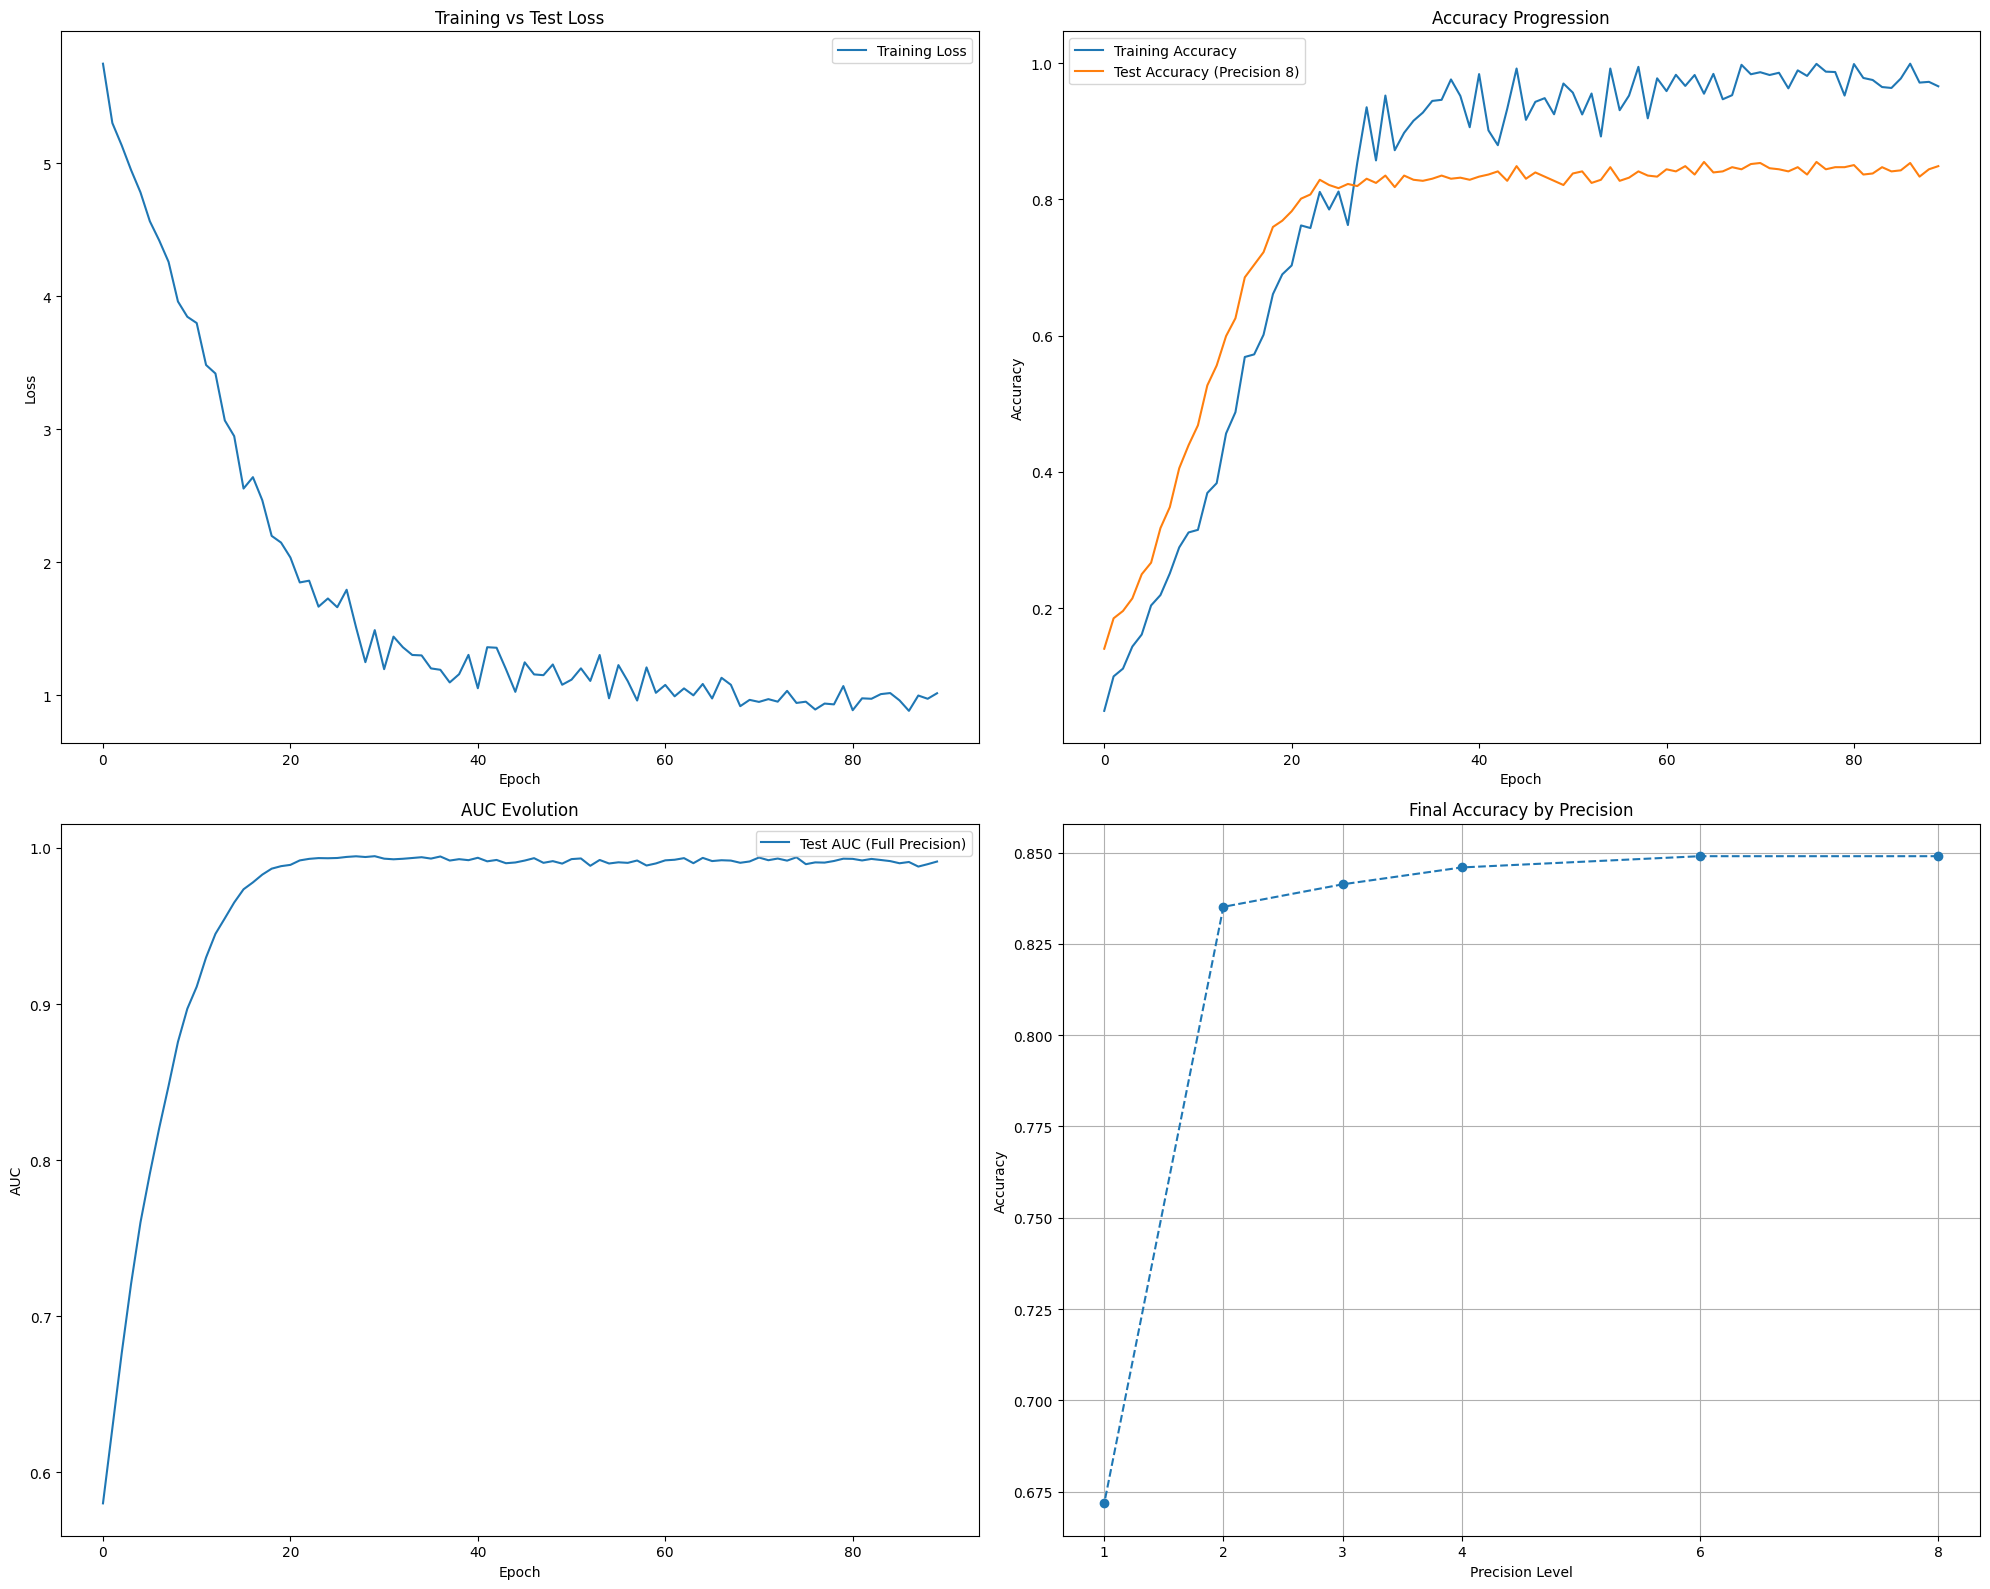


Final Evaluation Results:

Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       0.67      1.00      0.80         2
         Alejandro_Toledo       0.71      0.83      0.77         6
             Alvaro_Uribe       0.80      0.80      0.80         5
          Amelie_Mauresmo       0.75      1.00      0.86         3
             Andre_Agassi       0.80      0.80      0.80         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.33      0.50         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.33      0.50      0.40         2
            Ari_Fleischer       0.00      0.00      0.00         2
             Ariel_Sharon       0.85      0.92      0.88        12
    Arnold_Schwarzenegger       1.00      0.83      0.91       

In [4]:
# ====================== PART A ======================
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from tqdm import tqdm
import insightface
from insightface.app import FaceAnalysis
import albumentations as A
from torch.cuda.amp import autocast, GradScaler

class Config:
    dataset_path = 'dataset/lfw-deepfunneled/lfw-deepfunneled'
    min_samples_per_class = 10
    test_size = 0.15
    random_state = 42
    embedding_dim = 512
    transformer_dim = 1024
    num_heads = 8
    num_layers = 4
    dropout_rate = 0.3
    batch_size = 256
    epochs = 200
    learning_rate = 3e-4
    weight_decay = 1e-4
    patience = 25
    label_smoothing = 0.1
    grad_clip = 1.0
    precision_levels = [8, 6, 4, 3, 2, 1]
    noise_std = 0.2
    augment_prob = 0.8
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    num_workers = 0

class BiometricTransformer(nn.Module):
    def __init__(self, input_dim=512, num_classes=1680):
        super().__init__()
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=input_dim, nhead=Config.num_heads,
            dim_feedforward=Config.transformer_dim, dropout=Config.dropout_rate, activation='gelu'
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, Config.num_layers)
        self.feature_enhancer = nn.Sequential(
            nn.Linear(input_dim, Config.transformer_dim),
            nn.GELU(), nn.LayerNorm(Config.transformer_dim), nn.Dropout(Config.dropout_rate/2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(Config.transformer_dim, Config.transformer_dim//2),
            nn.GELU(), nn.LayerNorm(Config.transformer_dim//2),
            nn.Dropout(Config.dropout_rate), nn.Linear(Config.transformer_dim//2, num_classes)
        )
        self._init_weights()

    def _init_weights(self):
        for p in self.parameters():
            if p.dim() > 1: nn.init.xavier_normal_(p)

    def forward(self, x):
        x = self.transformer(x.unsqueeze(1)).squeeze(1)
        enhanced = self.feature_enhancer(x)
        return self.classifier(enhanced), enhanced

class BiometricDataset(Dataset):
    def __init__(self, embeddings, labels):
        self.embeddings = torch.from_numpy(np.array(embeddings)).float()
        self.labels = torch.from_numpy(np.array(labels)).long()
    
    def __len__(self): return len(self.labels)
    def __getitem__(self, idx): return self.embeddings[idx], self.labels[idx]

augmentation = A.Compose([
    A.HorizontalFlip(p=0.5), A.Rotate(limit=15, p=0.4),
    A.RandomBrightnessContrast(p=0.3), A.CLAHE(p=0.3),
    A.GaussNoise(p=0.2), A.ImageCompression(quality_lower=85, p=0.2)
])

def process_image(img_path):
    try:
        img = cv2.imread(img_path)
        if img is None: raise FileNotFoundError(f"Could not load image: {img_path}")
        if np.random.rand() < Config.augment_prob:
            img = augmentation(image=img)['image']
        img = cv2.resize(img, (112, 112))
        return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    except Exception as e:
        print(f"Error processing {img_path}: {str(e)}")
        return None

def simulate_fhe_effects(embeddings, decimals=3):
    scale = 10 ** decimals
    return np.round(embeddings * scale) / scale + np.random.normal(0, Config.noise_std/scale**0.5, embeddings.shape)

def train_model(model, train_loader, test_loader, label_map):
    optimizer = optim.AdamW(model.parameters(), lr=Config.learning_rate, weight_decay=Config.weight_decay)
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=Config.learning_rate*3, 
                                            total_steps=Config.epochs*len(train_loader))
    criterion = nn.CrossEntropyLoss(label_smoothing=Config.label_smoothing)
    scaler = GradScaler()
    
    best_acc, patience = 0, 0
    history = {'train_loss': [], 'train_acc': [], 'test_acc': {p: [] for p in Config.precision_levels},
               'test_loss': [], 'test_auc': []}

    for epoch in range(Config.epochs):
        model.train()
        epoch_loss, correct, total = 0, 0, 0
        
        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}')
        for emb, labels in pbar:
            if np.random.rand() > 0.3:
                precision = np.random.choice(Config.precision_levels)
                if precision != Config.precision_levels[0]:
                    emb = torch.tensor(simulate_fhe_effects(emb.numpy(), precision), dtype=torch.float32)
            
            emb, labels = emb.to(Config.device), labels.to(Config.device)
            optimizer.zero_grad()
            with autocast():
                outputs, _ = model(emb)
                loss = criterion(outputs, labels)
            
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            nn.utils.clip_grad_norm_(model.parameters(), Config.grad_clip)
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            
            epoch_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            pbar.set_postfix({'Loss': loss.item(), 'Acc': f"{correct/total:.2%}"})

        train_loss = epoch_loss / len(train_loader)
        train_acc = correct / total
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        
        model.eval()
        full_metrics = evaluate_model(model, test_loader, Config.precision_levels[0], label_map, criterion)
        history['test_loss'].append(full_metrics['loss'])
        history['test_auc'].append(full_metrics['auc'])
        history['test_acc'][Config.precision_levels[0]].append(full_metrics['accuracy'])
        
        for precision in Config.precision_levels[1:]:
            metrics = evaluate_model(model, test_loader, precision, label_map)
            history['test_acc'][precision].append(metrics['accuracy'])

        if full_metrics['accuracy'] > best_acc:
            best_acc = full_metrics['accuracy']
            torch.save(model.state_dict(), 'best_model.pth')
            patience = 0
        else: patience += 1
            
        if patience >= Config.patience:
            print(f"\nEarly stopping at epoch {epoch+1}")
            break
        
        print(f"\nEpoch {epoch+1} Summary:")
        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2%}")
        print(f"Test Loss: {full_metrics['loss']:.4f} | Test AUC: {full_metrics['auc']:.4f}")

    return history

def evaluate_model(model, loader, precision, label_map, criterion=None):
    model.eval()
    all_preds, all_labels, all_probs = [], [], []
    total_loss = 0.0
    
    with torch.no_grad():
        for emb, labels in loader:
            if precision < Config.precision_levels[0]:
                emb = torch.tensor(simulate_fhe_effects(emb.numpy(), precision), dtype=torch.float32)
            
            emb, labels = emb.to(Config.device), labels.to(Config.device)
            outputs, _ = model(emb)
            
            if criterion is not None:
                loss = criterion(outputs, labels)
                total_loss += loss.item() * labels.size(0)
            
            probs = torch.softmax(outputs, dim=1)
            all_probs.append(probs.cpu().numpy())
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = accuracy_score(all_labels, all_preds)
    loss = total_loss / len(loader.dataset) if len(loader.dataset) > 0 else 0
    auc = roc_auc_score(all_labels, np.concatenate(all_probs), multi_class='ovr', average='macro') if all_probs else 0
    
    if precision == Config.precision_levels[0]:
        print(f"\nClassification Report (Precision {precision}):")
        print(classification_report(all_labels, all_preds,
                                  target_names=[label_map[l] for l in np.unique(all_labels)],
                                  zero_division=0))
    
    return {'accuracy': accuracy, 'loss': loss, 'auc': auc}

def plot_results(history):
    plt.figure(figsize=(20, 16))
    plt.subplot(2, 2, 1)
    plt.plot(history['train_loss'], label='Training Loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Training vs Test Loss'); plt.legend()
    
    plt.subplot(2, 2, 2)
    plt.plot(history['train_acc'], label='Training Accuracy')
    full_precision = Config.precision_levels[0]
    plt.plot(history['test_acc'][full_precision], label=f'Test Accuracy (Precision {full_precision})')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy Progression'); plt.legend()
    
    plt.subplot(2, 2, 3)
    plt.plot(history['test_auc'], label='Test AUC (Full Precision)')
    plt.xlabel('Epoch'); plt.ylabel('AUC'); plt.title('AUC Evolution'); plt.legend()
    
    plt.subplot(2, 2, 4)
    final_accuracies = [history['test_acc'][p][-1] for p in Config.precision_levels]
    plt.plot(Config.precision_levels, final_accuracies, marker='o', linestyle='--')
    plt.xlabel('Precision Level'); plt.ylabel('Accuracy'); plt.title('Final Accuracy by Precision')
    plt.xticks(Config.precision_levels); plt.grid(True)
    plt.tight_layout(); plt.show()

if __name__ == "__main__":
    app = FaceAnalysis(name='buffalo_l', providers=['CUDAExecutionProvider', 'CPUExecutionProvider'])
    app.prepare(ctx_id=0, det_size=(224, 224))
    
    identity_dict = {}
    for person in os.listdir(Config.dataset_path):
        person_dir = os.path.join(Config.dataset_path, person)
        if os.path.isdir(person_dir):
            images = [os.path.join(person_dir, f) for f in os.listdir(person_dir) if f.lower().endswith('.jpg')]
            if len(images) >= Config.min_samples_per_class:
                identity_dict[person] = images
                
    valid_identities = sorted([k for k, v in identity_dict.items() if len(v) >= Config.min_samples_per_class])
    name_to_label = {name: idx for idx, name in enumerate(valid_identities)}
    label_map = {v: k for k, v in name_to_label.items()}

    all_embeddings, all_labels = [], []
    for person, images in identity_dict.items():
        if person not in valid_identities: continue
        label = name_to_label[person]
        for img_path in images:
            img = process_image(img_path)
            if img is None: continue
            embedding = app.models['recognition'].get_feat(img)
            embedding = embedding / np.linalg.norm(embedding)
            all_embeddings.append(embedding.astype(np.float32).ravel())
            all_labels.append(label)

    X_train, X_test, y_train, y_test = train_test_split(
        all_embeddings, all_labels, 
        test_size=max(Config.test_size, len(valid_identities)/len(all_labels)),
        stratify=all_labels,
        random_state=Config.random_state
    )
    
    train_loader = DataLoader(BiometricDataset(X_train, y_train), batch_size=Config.batch_size, shuffle=True)
    test_loader = DataLoader(BiometricDataset(X_test, y_test), batch_size=Config.batch_size)
    
    model = BiometricTransformer(input_dim=Config.embedding_dim, num_classes=len(valid_identities)).to(Config.device)
    history = train_model(model, train_loader, test_loader, label_map)
    plot_results(history)
    
    model.load_state_dict(torch.load('best_model.pth'))
    print("\nFinal Evaluation Results:")
    for precision in Config.precision_levels:
        metrics = evaluate_model(model, test_loader, precision, label_map)
        print(f"Precision {precision}: Acc={metrics['accuracy']:.2%} | AUC={metrics['auc']:.4f}")
    
    # Save transformed features
    model.eval()
    with torch.no_grad():
        X_train_tensor = torch.tensor(np.array(X_train), dtype=torch.float32).to(Config.device)
        X_test_tensor = torch.tensor(np.array(X_test), dtype=torch.float32).to(Config.device)
        _, enhanced_X_train = model(X_train_tensor)
        _, enhanced_X_test = model(X_test_tensor)
        
    np.save('partA_train_transformed.npy', enhanced_X_train.cpu().numpy())
    np.save('partA_test_transformed.npy', enhanced_X_test.cpu().numpy())
    np.save('partA_train_labels.npy', y_train)
    np.save('partA_test_labels.npy', y_test)

=== Accuracy Metrics ===
Euclidean:
  Avg Difference: 1.34e-06
  Std Dev: 9.96e-08
  Max Difference: 1.61e-06

Cosine:
  Avg Difference: 1.89e-06
  Std Dev: 1.28e-07
  Max Difference: 2.19e-06

=== Runtime Metrics ===
Generation:
  Avg: 0.0001s
  Std Dev: 0.0003s

Encryption:
  Avg: 0.0126s
  Std Dev: 0.0018s

Computation:
  Avg: 0.5081s
  Std Dev: 0.0427s

Decryption:
  Avg: 0.0018s
  Std Dev: 0.0004s



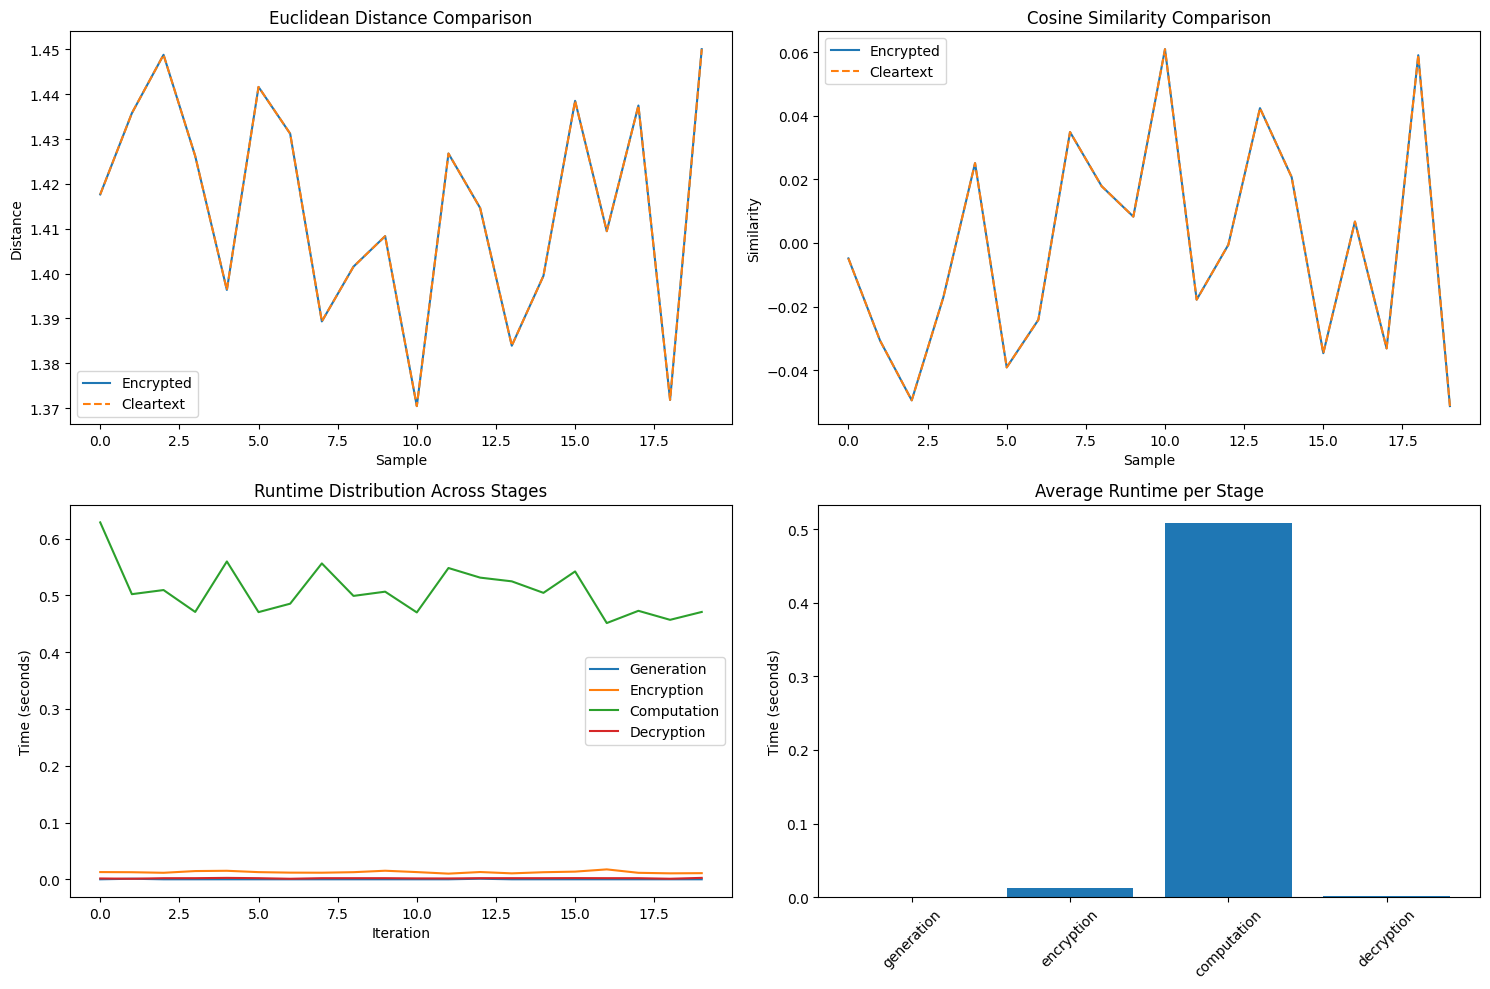


=== Final Demo ===
Euclidean Distance:
  Encrypted: 1.446248
  Cleartext: 1.446249
Cosine Similarity:
  Encrypted: -0.045816
  Cleartext: -0.045818


In [5]:
import time
import statistics
import numpy as np
import tenseal as ts
import matplotlib.pyplot as plt

# Configuration
VECTOR_DIM = 512
REPETITIONS = 20  # Reduced for practical testing
PLOT_SAMPLES = 50  # Number of samples to plot

# CKKS Context Setup
context = ts.context(
    ts.SCHEME_TYPE.CKKS,
    poly_modulus_degree=8192,
    coeff_mod_bit_sizes=[60, 40, 40, 60]
)
context.generate_galois_keys()
context.global_scale = 2 ** 40

def generate_normalized_vector():
    """Generate random vector and normalize it"""
    vec = np.random.randn(VECTOR_DIM)
    return vec / np.linalg.norm(vec)

def homomorphic_cosine_similarity(enc_vec1, enc_vec2):
    """Compute cosine similarity for normalized vectors (dot product)"""
    return enc_vec1.dot(enc_vec2)

def homomorphic_euclidean_distance(enc_vec1, enc_vec2):
    """Compute squared Euclidean distance for normalized vectors (2 - 2*dot)"""
    dot_product = enc_vec1.dot(enc_vec2)
    return 2 - 2 * dot_product

# Data collection structures
metrics = {
    'euclidean': {'encrypted': [], 'cleartext': [], 'difference': []},
    'cosine': {'encrypted': [], 'cleartext': [], 'difference': []},
    'timing': {
        'generation': [],
        'encryption': [],
        'computation': [],
        'decryption': []
    }
}

# Main evaluation loop
for _ in range(REPETITIONS):
    # Vector generation and normalization
    t_start = time.time()
    vec1 = generate_normalized_vector()
    vec2 = generate_normalized_vector()
    metrics['timing']['generation'].append(time.time() - t_start)
    
    # Encryption
    t_start = time.time()
    enc_vec1 = ts.ckks_vector(context, vec1)
    enc_vec2 = ts.ckks_vector(context, vec2)
    metrics['timing']['encryption'].append(time.time() - t_start)
    
    # Homomorphic computations
    t_start = time.time()
    enc_euc = homomorphic_euclidean_distance(enc_vec1, enc_vec2)
    enc_cos = homomorphic_cosine_similarity(enc_vec1, enc_vec2)
    metrics['timing']['computation'].append(time.time() - t_start)
    
    # Decryption and cleartext comparison
    t_start = time.time()
    # Cleartext calculations
    clear_cos = np.dot(vec1, vec2)
    clear_euc = np.linalg.norm(vec1 - vec2)
    
    # Decrypt and process encrypted results
    decrypted_euc_sq = enc_euc.decrypt()[0]
    decrypted_euc = np.sqrt(max(decrypted_euc_sq, 0))  # Handle potential negative values from noise
    decrypted_cos = enc_cos.decrypt()[0]
    
    # Store metrics
    metrics['euclidean']['encrypted'].append(decrypted_euc)
    metrics['euclidean']['cleartext'].append(clear_euc)
    metrics['euclidean']['difference'].append(abs(decrypted_euc - clear_euc))
    
    metrics['cosine']['encrypted'].append(decrypted_cos)
    metrics['cosine']['cleartext'].append(clear_cos)
    metrics['cosine']['difference'].append(abs(decrypted_cos - clear_cos))
    metrics['timing']['decryption'].append(time.time() - t_start)

# Visualization functions
def plot_metrics():
    plt.figure(figsize=(15, 10))
    
    # Euclidean Distance Comparison
    plt.subplot(2, 2, 1)
    plt.plot(metrics['euclidean']['encrypted'][:PLOT_SAMPLES], label='Encrypted')
    plt.plot(metrics['euclidean']['cleartext'][:PLOT_SAMPLES], '--', label='Cleartext')
    plt.title("Euclidean Distance Comparison")
    plt.xlabel("Sample")
    plt.ylabel("Distance")
    plt.legend()
    
    # Cosine Similarity Comparison
    plt.subplot(2, 2, 2)
    plt.plot(metrics['cosine']['encrypted'][:PLOT_SAMPLES], label='Encrypted')
    plt.plot(metrics['cosine']['cleartext'][:PLOT_SAMPLES], '--', label='Cleartext')
    plt.title("Cosine Similarity Comparison")
    plt.xlabel("Sample")
    plt.ylabel("Similarity")
    plt.legend()
    
    # Runtime Distribution
    plt.subplot(2, 2, 3)
    for stage in ['generation', 'encryption', 'computation', 'decryption']:
        plt.plot(metrics['timing'][stage], label=stage.capitalize())
    plt.title("Runtime Distribution Across Stages")
    plt.xlabel("Iteration")
    plt.ylabel("Time (seconds)")
    plt.legend()
    
    # Average Runtime
    plt.subplot(2, 2, 4)
    avg_times = [statistics.mean(metrics['timing'][stage]) for stage in metrics['timing']]
    plt.bar(metrics['timing'].keys(), avg_times)
    plt.title("Average Runtime per Stage")
    plt.ylabel("Time (seconds)")
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

# Generate and display results
print("=== Accuracy Metrics ===")
for metric in ['euclidean', 'cosine']:
    avg_diff = statistics.mean(metrics[metric]['difference'])
    std_diff = statistics.pstdev(metrics[metric]['difference']) if len(metrics[metric]['difference']) > 1 else 0
    max_diff = max(metrics[metric]['difference'])
    print(f"{metric.capitalize()}:\n  Avg Difference: {avg_diff:.2e}\n  Std Dev: {std_diff:.2e}\n  Max Difference: {max_diff:.2e}\n")

print("=== Runtime Metrics ===")
for stage in metrics['timing']:
    avg_time = statistics.mean(metrics['timing'][stage])
    std_time = statistics.pstdev(metrics['timing'][stage]) if len(metrics['timing'][stage]) > 1 else 0
    print(f"{stage.capitalize()}:\n  Avg: {avg_time:.4f}s\n  Std Dev: {std_time:.4f}s\n")

# Generate visualizations
plot_metrics()

# Final demo
print("\n=== Final Demo ===")
demo_vec1 = generate_normalized_vector()
demo_vec2 = generate_normalized_vector()
enc_demo1 = ts.ckks_vector(context, demo_vec1)
enc_demo2 = ts.ckks_vector(context, demo_vec2)

# Homomorphic computations
enc_euc = homomorphic_euclidean_distance(enc_demo1, enc_demo2)
enc_cos = homomorphic_cosine_similarity(enc_demo1, enc_demo2)

# Decryption and processing
decrypted_euc_sq = enc_euc.decrypt()[0]
decrypted_euc = np.sqrt(max(decrypted_euc_sq, 0))
decrypted_cos = enc_cos.decrypt()[0]

# Cleartext calculations
clear_euc = np.linalg.norm(demo_vec1 - demo_vec2)
clear_cos = np.dot(demo_vec1, demo_vec2)

print(f"Euclidean Distance:\n  Encrypted: {decrypted_euc:.6f}\n  Cleartext: {clear_euc:.6f}")
print(f"Cosine Similarity:\n  Encrypted: {decrypted_cos:.6f}\n  Cleartext: {clear_cos:.6f}")

Generating cleartext results...

Running homomorphic processing...
Processing sample 1/10
Processing sample 2/10
Processing sample 3/10
Processing sample 4/10
Processing sample 5/10
Processing sample 6/10
Processing sample 7/10
Processing sample 8/10
Processing sample 9/10
Processing sample 10/10

Calculating accuracy metrics...


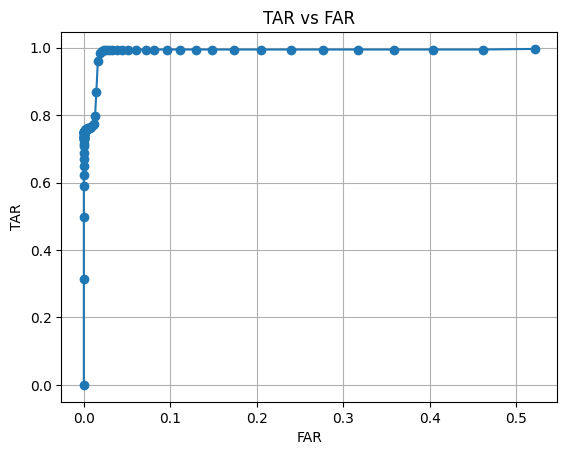

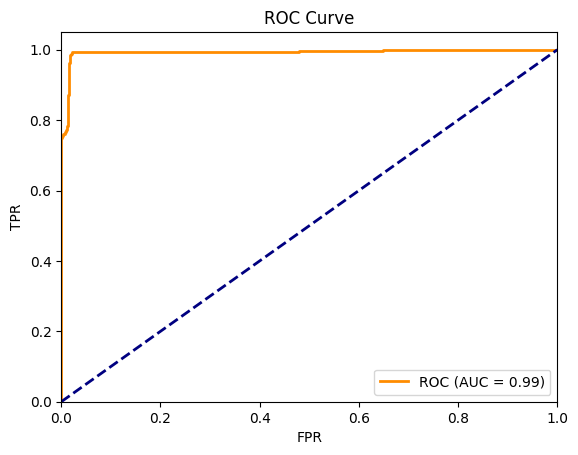


=== Accuracy Results ===
Score Differences:
  Avg: 2.22e-06
  Max: 2.90e-06
Top-K Accuracy:
  Top-1: 100.00%
  Top-2: 100.00%
  Top-3: 100.00%
  Top-4: 100.00%
  Top-5: 100.00%
  Top-6: 100.00%
  Top-7: 100.00%
  Top-8: 100.00%
  Top-9: 100.00%
  Top-10: 100.00%

=== Performance Metrics ===
Encryption: 0.0051s/sample
Computation: 18.9801s/sample
Decryption: 0.8194s/sample
Total: 19.8046s/sample
Ciphertext Size: 0.32MB


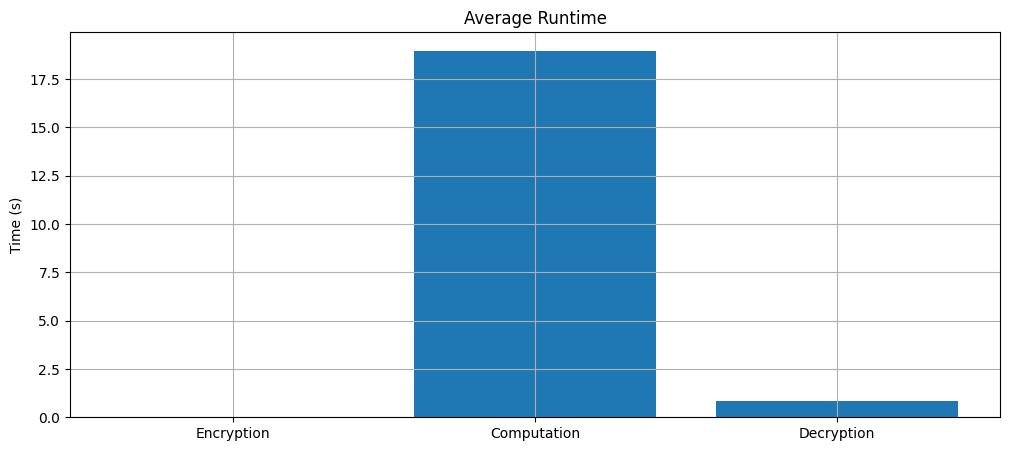

In [2]:
# ====================== PART C ======================
import time
import numpy as np
import pandas as pd
import tenseal as ts
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

VECTOR_DIM = 512
NUM_TEMPLATES = 1000
NUM_TEST_SAMPLES = 10
TOP_K = 10
CKKS_PARAMS = {
    "poly_modulus_degree": 8192,
    "coeff_mod_bit_sizes": [60, 40, 40, 60],
    "global_scale": 2**40
}

# Load transformed embeddings from Part A
X_train = np.load('partA_train_transformed.npy')[:NUM_TEMPLATES]
X_test = np.load('partA_test_transformed.npy')[:NUM_TEST_SAMPLES]
y_test = np.load('partA_test_labels.npy')[:NUM_TEST_SAMPLES]
y_train = np.load('partA_train_labels.npy')[:NUM_TEMPLATES]

# Normalize to unit vectors
X_train = X_train / np.linalg.norm(X_train, axis=1, keepdims=True)
X_test = X_test / np.linalg.norm(X_test, axis=1, keepdims=True)

def generate_cleartext_results():
    print("Generating cleartext results...")
    scores = np.dot(X_test, X_train.T)  # Cosine similarity
    top10_indices = np.argsort(-scores, axis=1)[:, :TOP_K]
    pd.DataFrame(scores).to_csv('scores.csv', index=False)
    pd.DataFrame(top10_indices).to_csv('top10.csv', index=False)
    return scores, top10_indices

cleartext_scores, cleartext_top10 = generate_cleartext_results()

class HomomorphicBiometricSystem:
    def __init__(self):
        self.context = ts.context(
            ts.SCHEME_TYPE.CKKS,
            poly_modulus_degree=CKKS_PARAMS["poly_modulus_degree"],
            coeff_mod_bit_sizes=CKKS_PARAMS["coeff_mod_bit_sizes"]
        )
        self.context.generate_galois_keys()
        self.context.global_scale = CKKS_PARAMS["global_scale"]
        self.encrypted_templates = [ts.ckks_vector(self.context, vec) for vec in X_train]
        
    def process_sample(self, sample):
        t_start = time.time()
        enc_sample = ts.ckks_vector(self.context, sample)
        encrypt_time = time.time() - t_start
        
        t_start = time.time()
        similarities = [enc_sample.dot(template) for template in self.encrypted_templates]
        compute_time = time.time() - t_start
        
        t_start = time.time()
        decrypted = np.array([s.decrypt()[0] for s in similarities])
        decrypt_time = time.time() - t_start
        
        return {'scores': decrypted, 'timing': (encrypt_time, compute_time, decrypt_time)}

def homomorphic_processing():
    print("\nRunning homomorphic processing...")
    system = HomomorphicBiometricSystem()
    homomorphic_scores = []
    homomorphic_top10 = []
    timing_metrics = {'encryption': [], 'computation': [], 'decryption': []}
    
    for idx, sample in enumerate(X_test):
        print(f"Processing sample {idx+1}/{len(X_test)}")
        result = system.process_sample(sample)
        homomorphic_scores.append(result['scores'])
        homomorphic_top10.append(np.argsort(-result['scores'])[:TOP_K])
        t_enc, t_comp, t_dec = result['timing']
        timing_metrics['encryption'].append(t_enc)
        timing_metrics['computation'].append(t_comp)
        timing_metrics['decryption'].append(t_dec)
    
    pd.DataFrame(homomorphic_scores).to_csv('scores_dec.csv', index=False)
    pd.DataFrame(homomorphic_top10).to_csv('top10_dec.csv', index=False)
    return homomorphic_scores, homomorphic_top10, timing_metrics

hom_scores, hom_top10, timings = homomorphic_processing()

def calculate_accuracy():
    print("\nCalculating accuracy metrics...")
    cleartext_top10_arr = np.array(cleartext_top10)
    hom_top10_arr = np.array(hom_top10)
    score_diffs = np.abs(cleartext_scores - np.array(hom_scores))
    
    score_metrics = {
        'avg_diff': np.mean(score_diffs),
        'max_diff': np.max(score_diffs),
        'min_diff': np.min(score_diffs),
        'std_diff': np.std(score_diffs)
    }
    
    topk_accuracies = []
    for k in range(TOP_K):
        matches = np.sum(cleartext_top10_arr[:, k] == hom_top10_arr[:, k])
        topk_accuracies.append(matches / len(X_test))
    
    return score_metrics, topk_accuracies

score_metrics, topk_acc = calculate_accuracy()

def calculate_performance(timings):
    perf_metrics = {
        'encryption_avg': np.mean(timings['encryption']),
        'computation_avg': np.mean(timings['computation']),
        'decryption_avg': np.mean(timings['decryption']),
        'total_avg': np.sum([np.mean(timings[k]) for k in timings])
    }
    
    dummy_ct = ts.ckks_vector(HomomorphicBiometricSystem().context, X_test[0]).serialize()
    perf_metrics['ciphertext_size'] = len(dummy_ct) / (1024 * 1024)
    
    return perf_metrics

perf_metrics = calculate_performance(timings)

def calculate_tar_far(scores, labels, thresholds):
    tar, far = [], []
    for threshold in thresholds:
        true_accepts = np.sum((scores >= threshold) & (labels == 1))
        false_accepts = np.sum((scores >= threshold) & (labels == 0))
        tar.append(true_accepts / np.sum(labels == 1))
        far.append(false_accepts / np.sum(labels == 0))
    return tar, far

# Generate labels (1 if same identity, 0 otherwise)
genuine_mask = np.array([[y_test[i] == train_label for train_label in y_train] 
                       for i in range(len(y_test))]).flatten()
all_labels = np.concatenate([genuine_mask, genuine_mask])
all_scores = np.concatenate([cleartext_scores.flatten(), np.array(hom_scores).flatten()])

# Calculate ROC metrics
fpr, tpr, _ = roc_curve(all_labels, all_scores)
roc_auc = auc(fpr, tpr)

# Calculate TAR/FAR
THRESHOLDS = np.linspace(0, 1, 100)
tar, far = calculate_tar_far(all_scores, all_labels, THRESHOLDS)

plt.figure()
plt.plot(far, tar, marker='o')
plt.xlabel('FAR'); plt.ylabel('TAR'); plt.title('TAR vs FAR'); plt.grid(True); plt.show()

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC Curve'); plt.legend(); plt.show()

print("\n=== Accuracy Results ===")
print(f"Score Differences:\n  Avg: {score_metrics['avg_diff']:.2e}\n  Max: {score_metrics['max_diff']:.2e}")
print(f"Top-K Accuracy:")
for k, acc in enumerate(topk_acc): print(f"  Top-{k+1}: {acc:.2%}")

print("\n=== Performance Metrics ===")
print(f"Encryption: {perf_metrics['encryption_avg']:.4f}s/sample")
print(f"Computation: {perf_metrics['computation_avg']:.4f}s/sample")
print(f"Decryption: {perf_metrics['decryption_avg']:.4f}s/sample")
print(f"Total: {perf_metrics['total_avg']:.4f}s/sample")
print(f"Ciphertext Size: {perf_metrics['ciphertext_size']:.2f}MB")

plt.figure(figsize=(12, 5))
plt.bar(['Encryption', 'Computation', 'Decryption'], 
        [perf_metrics['encryption_avg'], 
         perf_metrics['computation_avg'], 
         perf_metrics['decryption_avg']])
plt.ylabel('Time (s)'); plt.title('Average Runtime'); plt.grid(True); plt.show()